In [17]:
# Clear all variables from workspace
%reset -f

In [29]:
import pandas as pd
import numpy as np
import joblib
import time
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNetCV
from sklearn.svm import SVR

# Load data
df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_subsample.csv")
df = df.drop(columns=['time_elapsed'])

# Rename column for clarity
df = df.rename(columns={'nihtbx_totalcomp_uncorrected': 'cc_score'})

# Separate X and y
X_covariates = [
    'sex',
    'r_e_white', 'r_e_black', 'r_e_Hispanic', 'r_e_Asian', 'r_e_Other',
    'interview_age',
    'p_e_2ndgrade', 'p_e_3rdgrade', 'p_e_4thgrade', 'p_e_5thgrade',
    'p_e_6thgrade', 'p_e_7thgrade', 'p_e_8thgrade', 'p_e_9thgrade',
    'p_e_10thgrade', 'p_e_11thgrade', 'p_e_12thgrade',
    'p_e_highschool', 'p_e_GED_ediploma', 'p_e_college',
    'p_e_adeg_o', 'p_e_adeg_a', 'p_e_ba_deg', 'p_e_ma_deg',
    'p_e_pro_sch', 'p_e_doc_deg', 'p_e_refuse',
    'scanner_disco', 'scanner_ingenia', 'scanner_prisma',
    'scanner_prismafit'
]

X_columns = [f'X{i}' for i in range(1, 7022)]
X_cov = df[X_covariates].values
X = df[X_columns].values
y = df['cc_score'].values

C:\Users\Shih Yang\AppData\Local\Temp\ipykernel_30984\1619192810.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='cc_score', data=plot_df, palette='Set2')


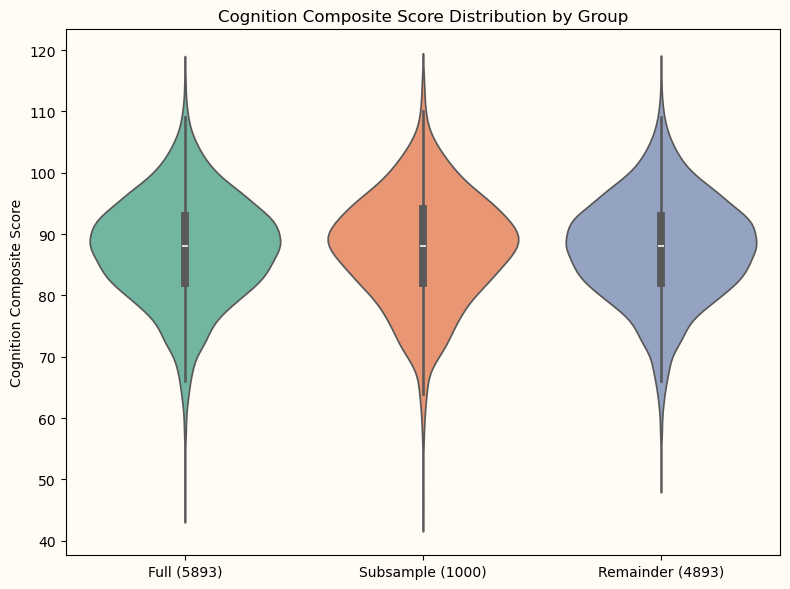

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all datasets
full_df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_full.csv")
subsample_df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_subsample.csv")
remainder_df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_subsample_remainder.csv")

# Rename for consistency
for df in [full_df, subsample_df, remainder_df]:
    df.rename(columns={'nihtbx_totalcomp_uncorrected': 'cc_score'}, inplace=True)

# Prepare data for plotting
plot_df = pd.DataFrame({
    'cc_score': pd.concat([
        full_df['cc_score'],
        subsample_df['cc_score'],
        remainder_df['cc_score']
    ], ignore_index=True),
    'Group': (['Full (5893)'] * len(full_df)) +
             (['Subsample (1000)'] * len(subsample_df)) +
             (['Remainder (4893)'] * len(remainder_df))
})

plt.figure(figsize=(8, 6), facecolor='#fffcf5') #outer background color
sns.violinplot(x='Group', y='cc_score', data=plot_df, palette='Set2')
plt.title('Cognition Composite Score Distribution by Group')
plt.ylabel('Cognition Composite Score')
plt.xlabel('')
plt.gca().set_facecolor('#fffcf5')  # inner background color
plt.tight_layout()
plt.show()

In [ ]:
#Set the parameters for cross-validation
n_repeats = 100
outer_folds = 5
inner_folds = 5
test_size = 0.3

# Initialize lists to store results
results = []
ridge_coefs = []
lasso_coefs = []
ridge_models = []
lasso_models = []
svr_models = []
elasticnet_coefs = []
elasticnet_models = []

for repeat in tqdm(range(n_repeats), desc="Repeats"):
    # Split train/test
    X_cov_train, X_cov_test, X_X_train, X_X_test, y_train, y_test = train_test_split(
        X_cov, X, y, test_size=test_size, random_state=repeat
    )
    # Fit covariates (OLS, unpenalized)
    ols = LinearRegression().fit(X_cov_train, y_train)
    y_train_resid = y_train - ols.predict(X_cov_train)
    y_test_resid = y_test - ols.predict(X_cov_test)
    
    # Outer CV
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=repeat)
    for train_idx, val_idx in tqdm(list(outer_cv.split(X_X_train)), desc=f"Outer CV (repeat {repeat+1})", leave=False):
        X_train_fold, X_val_fold = X_X_train[train_idx], X_X_train[val_idx]
        y_train_fold, y_val_fold = y_train_resid[train_idx], y_train_resid[val_idx]
        
        # Inner CV for alpha
        alphas = np.logspace(-4, 4, 20)
        
        # Ridge
        ridge_cv = RidgeCV(alphas=alphas, cv=inner_folds).fit(X_train_fold, y_train_fold)
        best_alpha_ridge = ridge_cv.alpha_
        ridge = RidgeCV(alphas=[best_alpha_ridge]).fit(X_train_fold, y_train_fold)
        y_pred_ridge = ridge.predict(X_val_fold)
        mse_ridge = mean_squared_error(y_val_fold, y_pred_ridge)
        r2_ridge = r2_score(y_val_fold, y_pred_ridge)
        results.append({'repeat': repeat, 'model': 'ridge', 'mse': mse_ridge, 'r2': r2_ridge, 'alpha': best_alpha_ridge})
        ridge_coefs.append({'repeat': repeat, 'coef': ridge.coef_, 'intercept': ridge.intercept_})
        ridge_models.append(ridge)
        
        # Lasso
        lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 20), cv=inner_folds, max_iter=10000).fit(X_train_fold, y_train_fold)
        best_alpha_lasso = lasso_cv.alpha_
        lasso = LassoCV(alphas=[best_alpha_lasso], max_iter=10000).fit(X_train_fold, y_train_fold)
        y_pred_lasso = lasso.predict(X_val_fold)
        mse_lasso = mean_squared_error(y_val_fold, y_pred_lasso)
        r2_lasso = r2_score(y_val_fold, y_pred_lasso)
        results.append({'repeat': repeat, 'model': 'lasso', 'mse': mse_lasso, 'r2': r2_lasso, 'alpha': best_alpha_lasso})
        lasso_coefs.append({'repeat': repeat, 'coef': lasso.coef_, 'intercept': lasso.intercept_})
        lasso_models.append(lasso)
        
        # SVR (linear kernel, C=1.0)
        svr = SVR(kernel='linear', C=1.0)
        svr.fit(X_train_fold, y_train_fold)
        y_pred_svr = svr.predict(X_val_fold)
        mse_svr = mean_squared_error(y_val_fold, y_pred_svr)
        r2_svr = r2_score(y_val_fold, y_pred_svr)
        results.append({'repeat': repeat, 'model': 'svr', 'mse': mse_svr, 'r2': r2_svr, 'alpha': None})
        svr_models.append(svr)

        # ElasticNet
        elasticnet_cv = ElasticNetCV(
            l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
            alphas=np.logspace(-4, 1, 20),
            cv=inner_folds,
            max_iter=10000
        ).fit(X_train_fold, y_train_fold)
        best_alpha_enet = elasticnet_cv.alpha_
        best_l1_ratio_enet = elasticnet_cv.l1_ratio_
        elasticnet = ElasticNetCV(
            l1_ratio=[best_l1_ratio_enet],
            alphas=[best_alpha_enet],
            max_iter=10000
        ).fit(X_train_fold, y_train_fold)
        y_pred_enet = elasticnet.predict(X_val_fold)
        mse_enet = mean_squared_error(y_val_fold, y_pred_enet)
        r2_enet = r2_score(y_val_fold, y_pred_enet)
        results.append({
            'repeat': repeat,
            'model': 'elasticnet',
            'mse': mse_enet,
            'r2': r2_enet,
            'alpha': best_alpha_enet,
            'l1_ratio': best_l1_ratio_enet
        })
        elasticnet_coefs.append({'repeat': repeat, 'coef': elasticnet.coef_, 'intercept': elasticnet.intercept_})
        elasticnet_models.append(elasticnet)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df.groupby(['model', 'repeat']).mean())

# Save Ridge coefficients and models
ridge_coefs_df = pd.DataFrame([
    {'repeat': c['repeat'], 'intercept': c['intercept'], **{f'coef_{i+1}': v for i, v in enumerate(c['coef'])}}
    for c in ridge_coefs
])
ridge_coefs_df.to_csv("subsample_ridge_coefs.csv", index=False)
joblib.dump(ridge_models, "subsample_ridge_models.joblib")

# Save Lasso coefficients and models
lasso_coefs_df = pd.DataFrame([
    {'repeat': c['repeat'], 'intercept': c['intercept'], **{f'coef_{i+1}': v for i, v in enumerate(c['coef'])}}
    for c in lasso_coefs
])
lasso_coefs_df.to_csv("subsample_lasso_coefs.csv", index=False)
joblib.dump(lasso_models, "subsample_lasso_models.joblib")

# Save SVR models
joblib.dump(svr_models, "subsample_svr_models.joblib")

# Save ElasticNet coefficients and models
elasticnet_coefs_df = pd.DataFrame([
    {'repeat': c['repeat'], 'intercept': c['intercept'], **{f'coef_{i+1}': v for i, v in enumerate(c['coef'])}}
    for c in elasticnet_coefs
])
elasticnet_coefs_df.to_csv("subsample_elasticnet_coefs.csv", index=False)
joblib.dump(elasticnet_models, "subsample_elasticnet_models.joblib")

# Save results to CSV
results_df.to_csv("subsample_rr_lasso_svr_results.csv", index=False)


Repeats: 100%|██████████| 100/100 [46:38:45<00:00, 1679.26s/it]  


                         mse        r2     alpha  l1_ratio
model      repeat                                         
elasticnet 0       52.996000  0.012766  0.428029      0.38
           1       57.045260 -0.001310  0.415403      0.28
           2       59.693239  0.011546  0.805352      0.10
           3       54.518031  0.008369  0.724837      0.10
           4       55.015770  0.005621  2.547664      0.10
...                      ...       ...       ...       ...
svr        95      76.955112 -0.333084       NaN       NaN
           96      65.855152 -0.235156       NaN       NaN
           97      71.786319 -0.369376       NaN       NaN
           98      61.924268 -0.283232       NaN       NaN
           99      69.323888 -0.303664       NaN       NaN

[400 rows x 4 columns]


C:\Users\Shih Yang\AppData\Local\Temp\ipykernel_30984\4068456367.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='r2', data=results_df, palette='Set2')


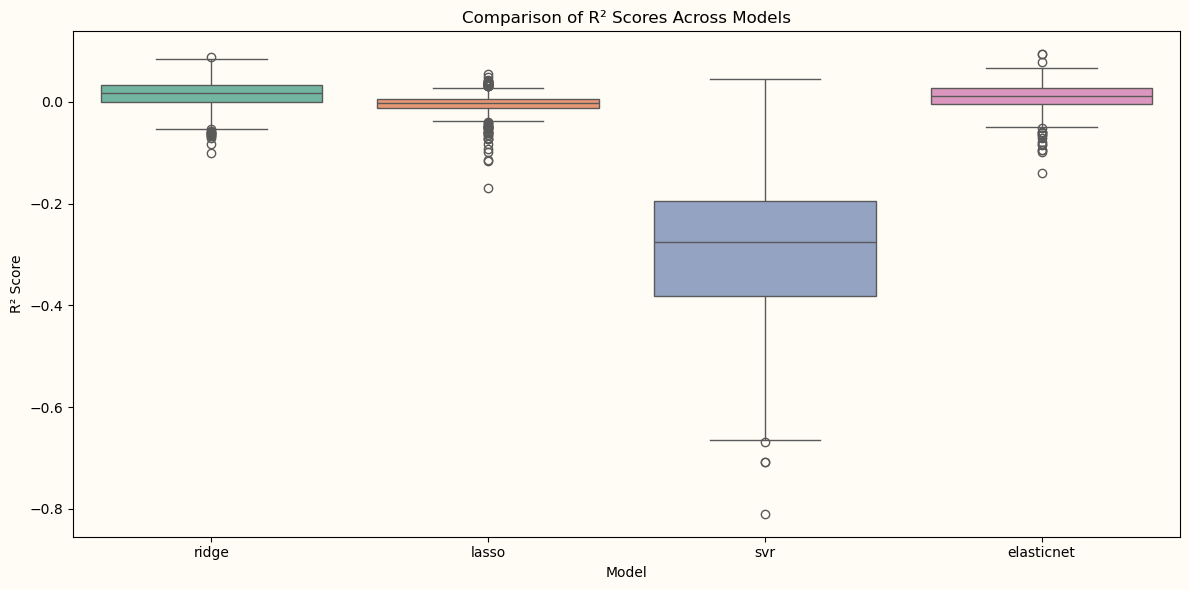

C:\Users\Shih Yang\AppData\Local\Temp\ipykernel_30984\4068456367.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mse', data=results_df, palette='Set2')


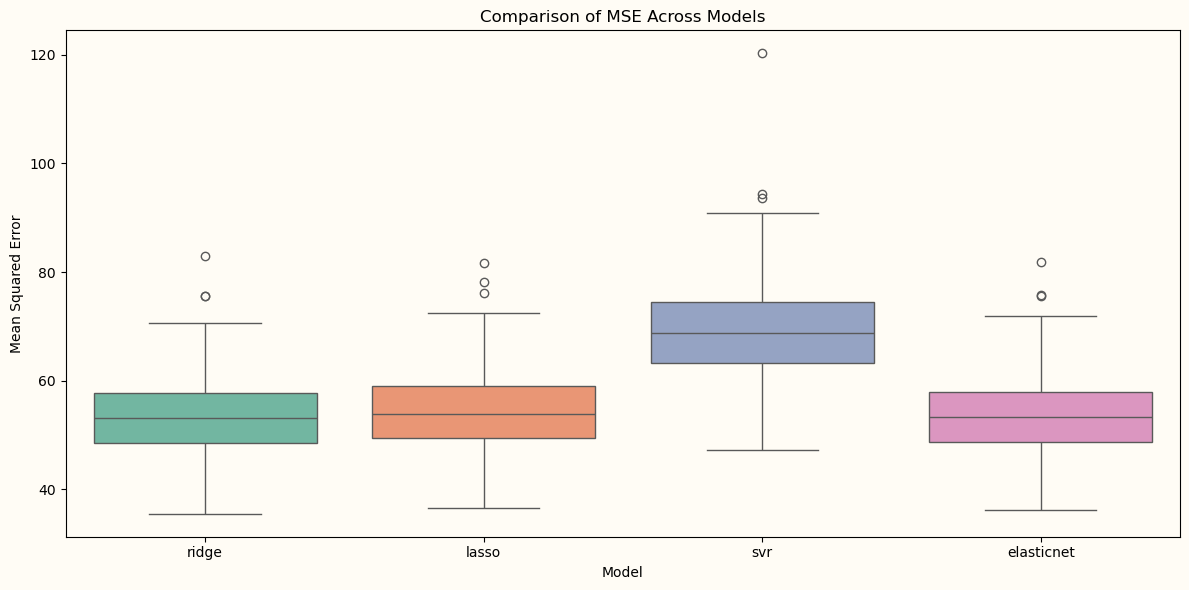

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results if not in memory
results_df = pd.read_csv("subsample_rr_lasso_svr_results.csv")

plt.figure(figsize=(12, 6), facecolor='#fffcf5')
sns.boxplot(x='model', y='r2', data=results_df, palette='Set2')
plt.title('Comparison of R² Scores Across Models')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

plt.figure(figsize=(12, 6), facecolor='#fffcf5')
sns.boxplot(x='model', y='mse', data=results_df, palette='Set2')
plt.title('Comparison of MSE Across Models')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

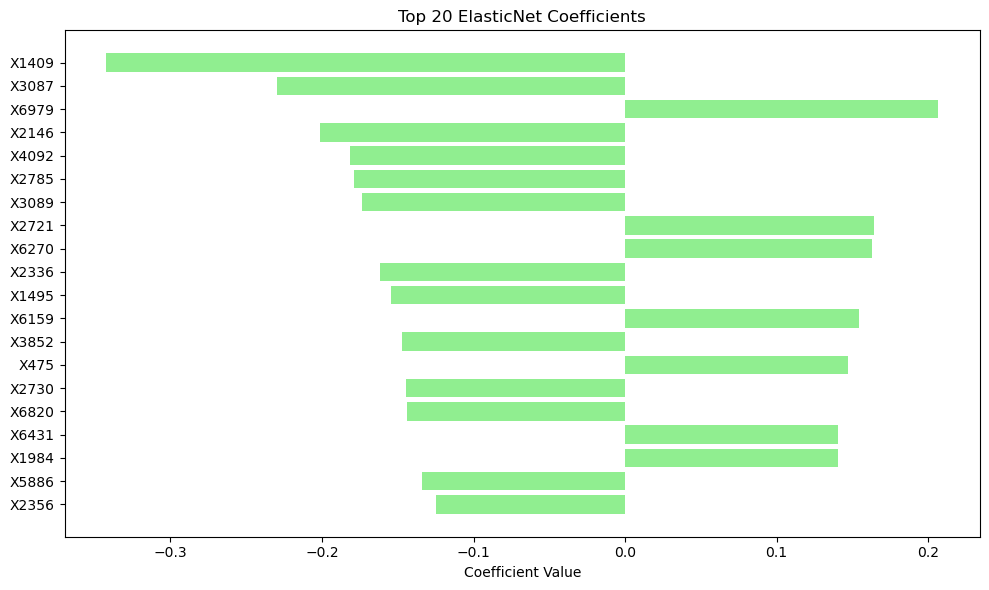

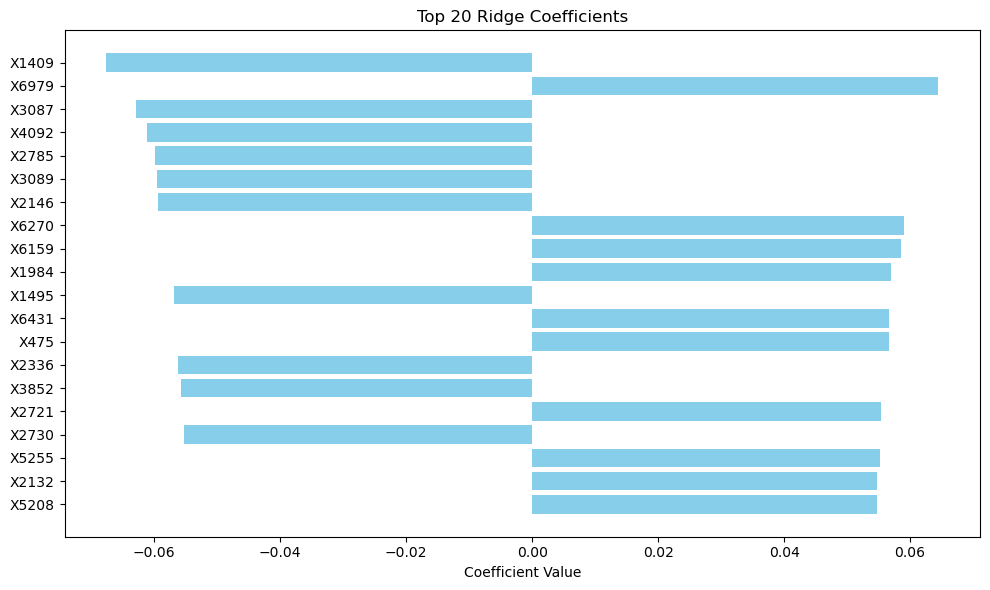

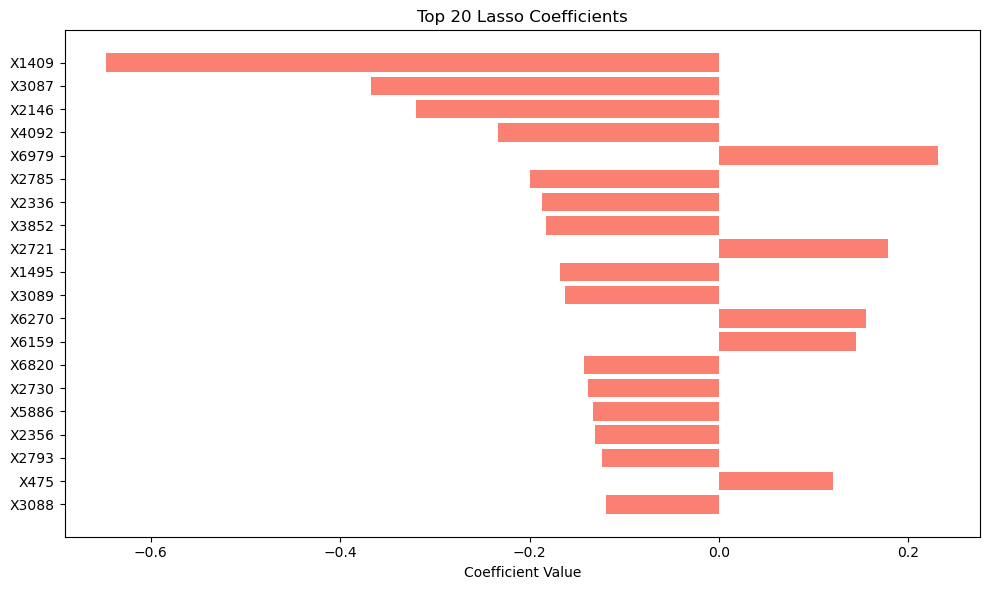

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load coefficients if not in memory
ridge_coefs_df = pd.read_csv("subsample_ridge_coefs.csv")
lasso_coefs_df = pd.read_csv("subsample_lasso_coefs.csv")
elastic_coefs_df = pd.read_csv("subsample_elasticnet_coefs.csv")

# Get only the coefficient columns (exclude 'repeat' and 'intercept')
coef_cols = [col for col in ridge_coefs_df.columns if col.startswith('coef_')]

# Compute average coefficients for each model
ridge_avg = ridge_coefs_df[coef_cols].mean(axis=0).values
lasso_avg = lasso_coefs_df[coef_cols].mean(axis=0).values
elastic_avg = elastic_coefs_df[coef_cols].mean(axis=0).values   

features = [f'X{i+1}' for i in range(len(coef_cols))]

# Create DataFrames for Ridge, Lasso and ElasticNet coefficients
ridge_df = pd.DataFrame({'Feature': features, 'Ridge': ridge_avg})
lasso_df = pd.DataFrame({'Feature': features, 'Lasso': lasso_avg})
elastic_df = pd.DataFrame({'Feature': features, 'Elastic': elastic_avg})

# Get top 20 features by absolute value for each model
top_n = 20
ridge_top = ridge_df.reindex(ridge_df['Ridge'].abs().sort_values(ascending=False).index).head(top_n)
lasso_top = lasso_df.reindex(lasso_df['Lasso'].abs().sort_values(ascending=False).index).head(top_n)
elastic_top = elastic_df.reindex(elastic_df['Elastic'].abs().sort_values(ascending=False).index).head(top_n)

# Plot ElasticNet
plt.figure(figsize=(10, 6))
plt.barh(np.arange(top_n), elastic_top['Elastic'], color='lightgreen')
plt.yticks(np.arange(top_n), elastic_top['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 ElasticNet Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Ridge
plt.figure(figsize=(10, 6))
plt.barh(np.arange(top_n), ridge_top['Ridge'], color='skyblue')
plt.yticks(np.arange(top_n), ridge_top['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot Lasso
plt.figure(figsize=(10, 6))
plt.barh(np.arange(top_n), lasso_top['Lasso'], color='salmon')
plt.yticks(np.arange(top_n), lasso_top['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Lasso Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

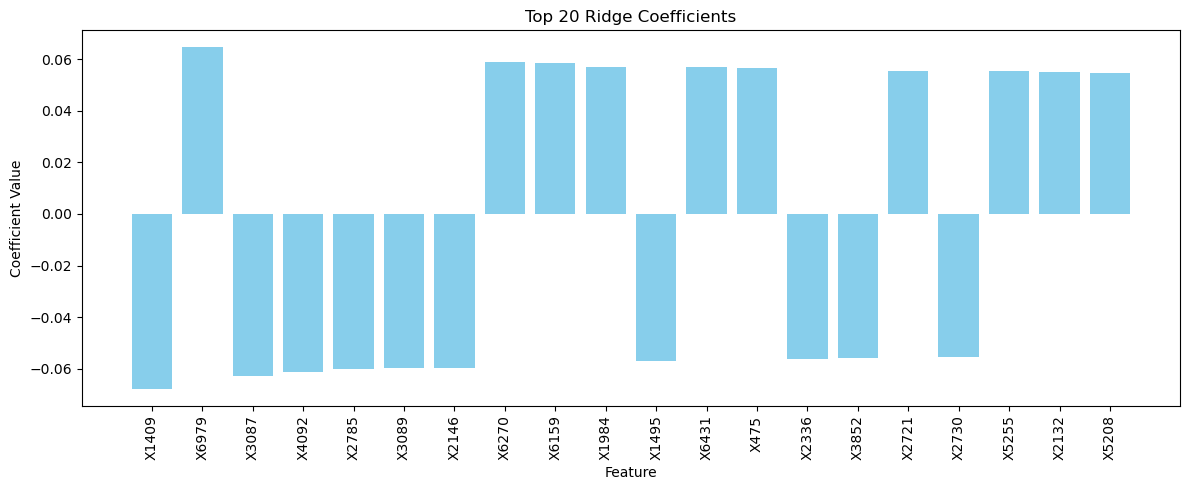

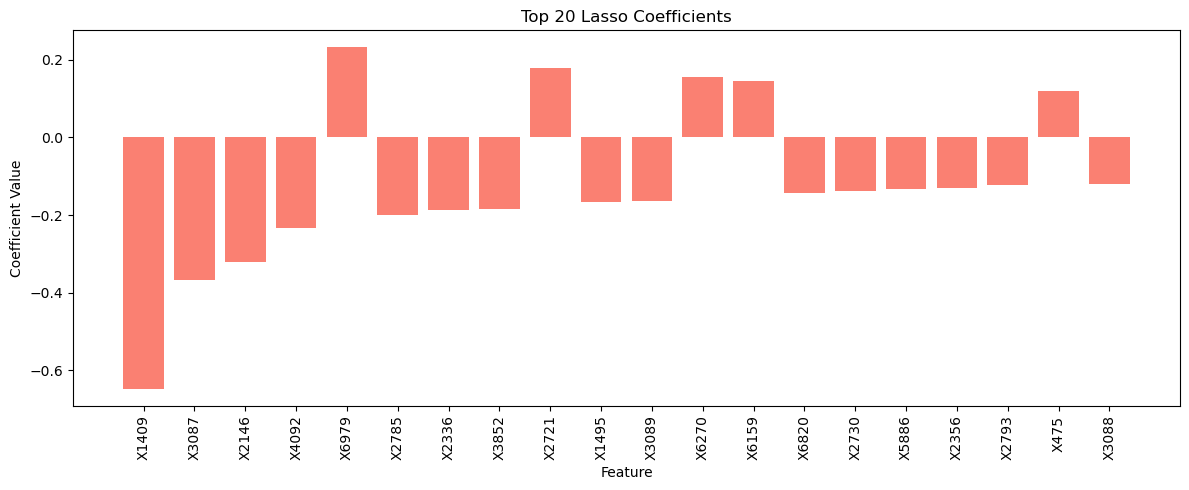

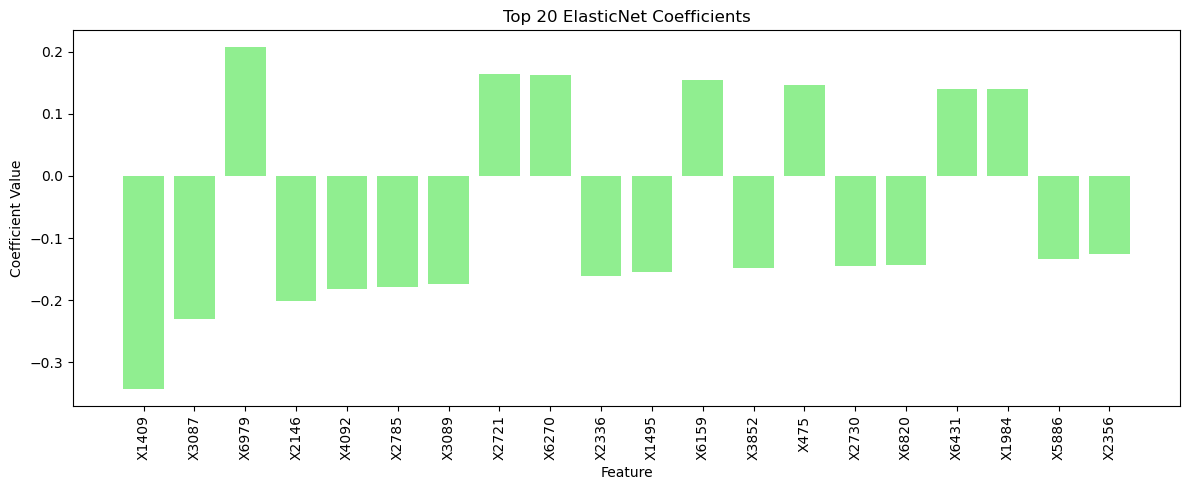

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load coefficient CSVs
ridge = pd.read_csv("subsample_ridge_coefs.csv")
lasso = pd.read_csv("subsample_lasso_coefs.csv")
elastic = pd.read_csv("subsample_elasticnet_coefs.csv")

# Get mean coefficients for each model
ridge_mean = ridge.filter(like='coef_').mean()
lasso_mean = lasso.filter(like='coef_').mean()
elastic_mean = elastic.filter(like='coef_').mean()

# Get top 20 features for each model
ridge_top = ridge_mean.abs().sort_values(ascending=False).head(20).index
lasso_top = lasso_mean.abs().sort_values(ascending=False).head(20).index
elastic_top = elastic_mean.abs().sort_values(ascending=False).head(20).index

# Plot for Ridge
plt.figure(figsize=(12, 5))
plt.bar(np.arange(20), ridge_mean[ridge_top], color='skyblue')
plt.xticks(np.arange(20), [f'X{int(f.split("_")[1])}' for f in ridge_top], rotation=90)
plt.title('Top 20 Ridge Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Plot for Lasso
plt.figure(figsize=(12, 5))
plt.bar(np.arange(20), lasso_mean[lasso_top], color='salmon')
plt.xticks(np.arange(20), [f'X{int(f.split("_")[1])}' for f in lasso_top], rotation=90)
plt.title('Top 20 Lasso Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# Plot for ElasticNet
plt.figure(figsize=(12, 5))
plt.bar(np.arange(20), elastic_mean[elastic_top], color='lightgreen')
plt.xticks(np.arange(20), [f'X{int(f.split("_")[1])}' for f in elastic_top], rotation=90)
plt.title('Top 20 ElasticNet Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

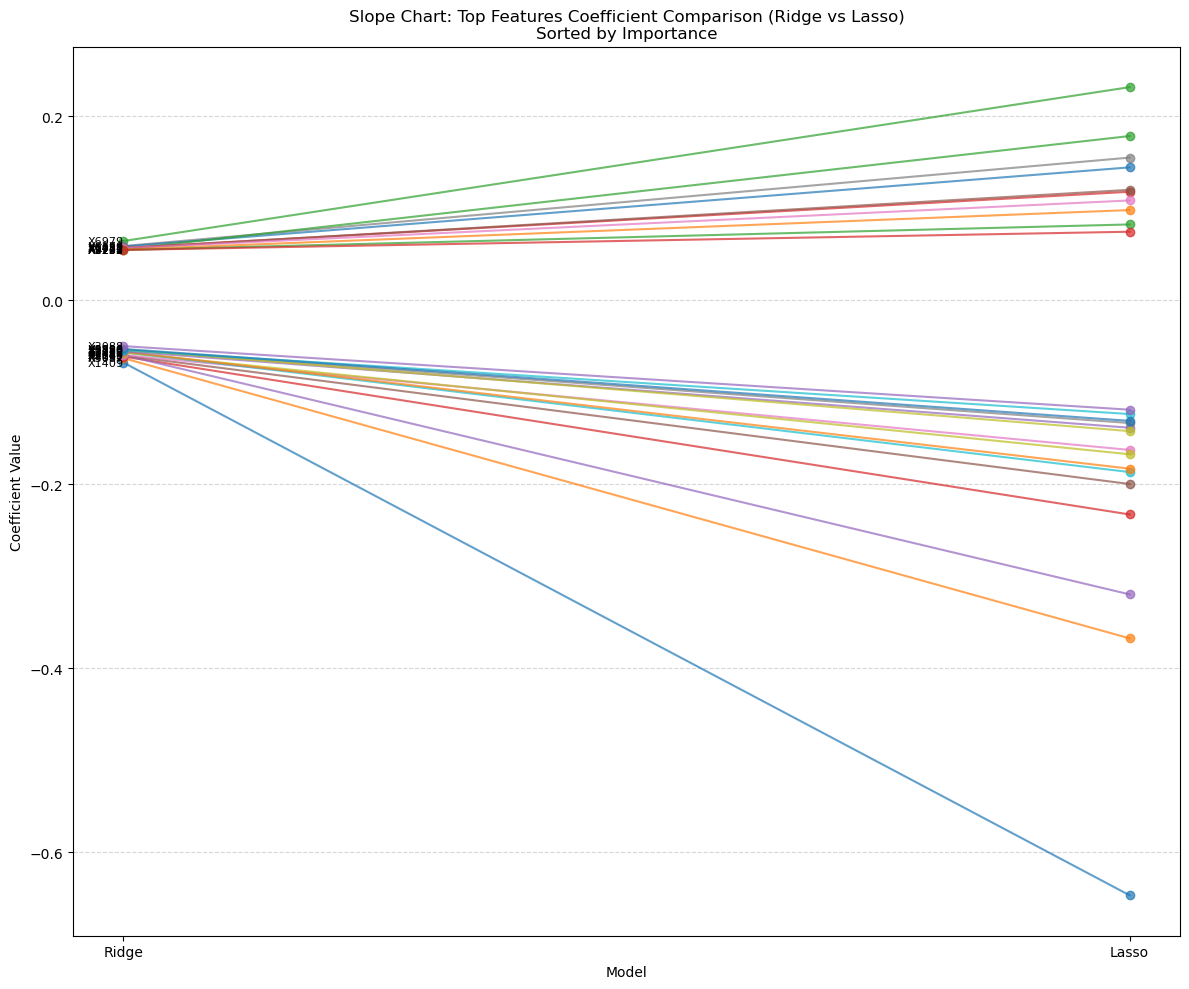

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load coefficient CSVs
ridge = pd.read_csv("subsample_ridge_coefs.csv")
lasso = pd.read_csv("subsample_lasso_coefs.csv")

# Get mean coefficients for each model
ridge_mean = ridge.filter(like='coef_').mean()
lasso_mean = lasso.filter(like='coef_').mean()

# Get top 20 features for each model
ridge_top = ridge_mean.abs().sort_values(ascending=False).head(20).index
lasso_top = lasso_mean.abs().sort_values(ascending=False).head(20).index

# Union of top features
all_top_features = list(set(ridge_top) | set(lasso_top))

# Prepare DataFrame for plotting
plot_df = pd.DataFrame({
    'Feature': all_top_features,
    'Ridge': ridge_mean[all_top_features].values,
    'Lasso': lasso_mean[all_top_features].values
}).fillna(0)

# For better labels
plot_df['Feature'] = plot_df['Feature'].str.replace('coef_', 'X')

# Compute ranks (1 = most important)
plot_df['Ridge_rank'] = plot_df['Ridge'].abs().rank(ascending=False, method='min')
plot_df['Lasso_rank'] = plot_df['Lasso'].abs().rank(ascending=False, method='min')
plot_df['Avg_rank'] = plot_df[['Ridge_rank', 'Lasso_rank']].mean(axis=1)

# Sort by average rank (or choose 'Ridge_rank' or 'Lasso_rank' if you prefer)
plot_df = plot_df.sort_values('Avg_rank').reset_index(drop=True)

# Slope chart
plt.figure(figsize=(12, 10))
for i, row in plot_df.iterrows():
    plt.plot(['Ridge', 'Lasso'], [row['Ridge'], row['Lasso']], marker='o', label=row['Feature'], alpha=0.7)
    plt.text('Ridge', row['Ridge'], row['Feature'], va='center', ha='right', fontsize=8)

plt.title('Slope Chart: Top Features Coefficient Comparison (Ridge vs Lasso)\nSorted by Importance')
plt.ylabel('Coefficient Value')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

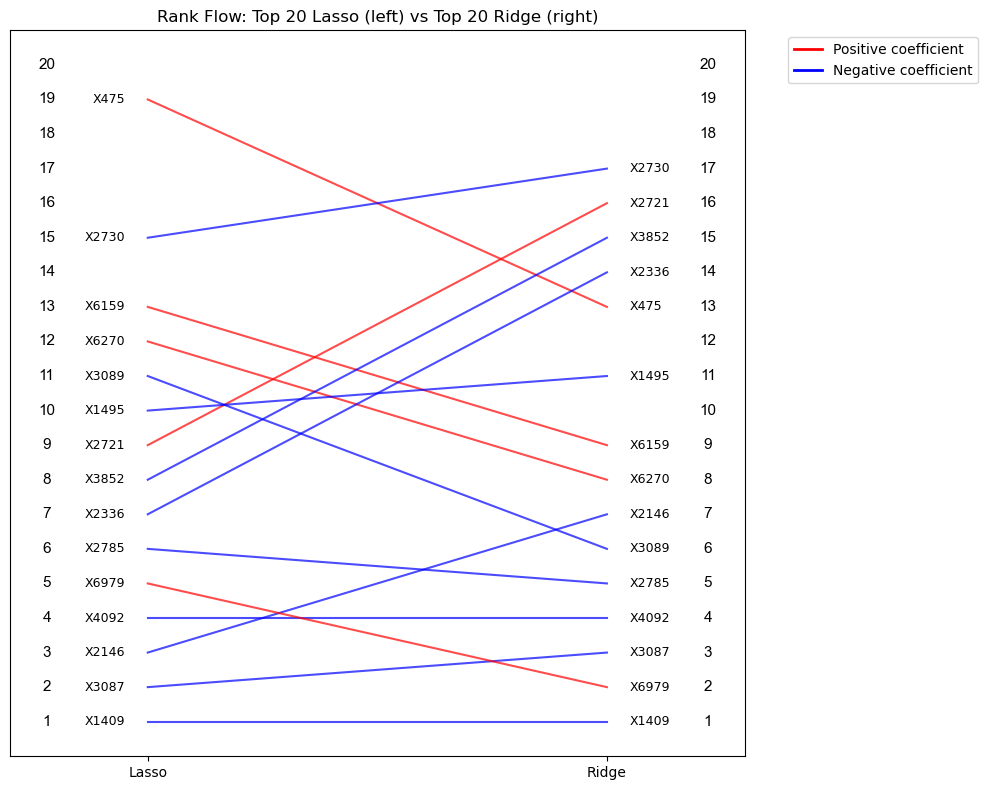

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load coefficient CSVs
ridge = pd.read_csv("subsample_ridge_coefs.csv")
lasso = pd.read_csv("subsample_lasso_coefs.csv")

# Get mean coefficients for each model
ridge_mean = ridge.filter(like='coef_').mean()
lasso_mean = lasso.filter(like='coef_').mean()

# Get top 20 features by absolute value for each model
ridge_top = ridge_mean.abs().sort_values(ascending=False).head(20).index.tolist()
lasso_top = lasso_mean.abs().sort_values(ascending=False).head(20).index.tolist()

def to_label(f): return f'X{int(f.split("_")[1])}'

# Create a DataFrame for all features in either top 20
all_features = list(set(left_features + right_features))
df = pd.DataFrame({
    'Feature': all_features,
    'Lasso_rank': [lasso_top.index(f) + 1 if f in lasso_top else np.nan for f in all_features],
    'Ridge_rank': [ridge_top.index(f) + 1 if f in ridge_top else np.nan for f in all_features],
    'Label': [to_label(f) for f in all_features],
    'Sign': [ridge_mean[f] if f in ridge_mean else 0 for f in all_features]
})

# Only keep features that are in at least one top 20
df = df.dropna(subset=['Lasso_rank', 'Ridge_rank'], how='all')

# Sort left and right for plotting, and keep only top 20
df_left = df.sort_values('Lasso_rank').reset_index(drop=True).iloc[:20]
df_right = df.sort_values('Ridge_rank').reset_index(drop=True).iloc[:20]

# Create mapping from feature to y-position on each side
left_pos = {f: i for i, f in enumerate(df_left['Feature'])}
right_pos = {f: i for i, f in enumerate(df_right['Feature'])}

plt.figure(figsize=(10, max(len(df_left), len(df_right)) * 0.4))

# Draw lines and feature labels
for _, row in df.iterrows():
    if row['Feature'] in left_pos and row['Feature'] in right_pos:
        y0 = left_pos[row['Feature']]
        y1 = right_pos[row['Feature']]
        color = 'red' if row['Sign'] > 0 else 'blue'
        plt.plot([0, 1], [y0, y1], color=color, alpha=0.7)
        plt.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=9)
        plt.text(1.05, y1, row['Label'], va='center', ha='left', fontsize=9)

# Add rank numbers 1-20 on both sides, spaced and with a different font
for i in range(len(df_left)):
    plt.text(-0.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')
for i in range(len(df_right)):
    plt.text(1.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')

plt.xlim(-0.3, 1.3)
plt.ylim(-1, max(len(df_left), len(df_right)))
plt.xticks([0, 1], ['Lasso', 'Ridge'])
plt.yticks([])
plt.title('Rank Flow: Top 20 Lasso (left) vs Top 20 Ridge (right)')
from matplotlib.lines import Line2D
plt.legend([Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='blue', lw=2)],
           ['Positive coefficient', 'Negative coefficient'],
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

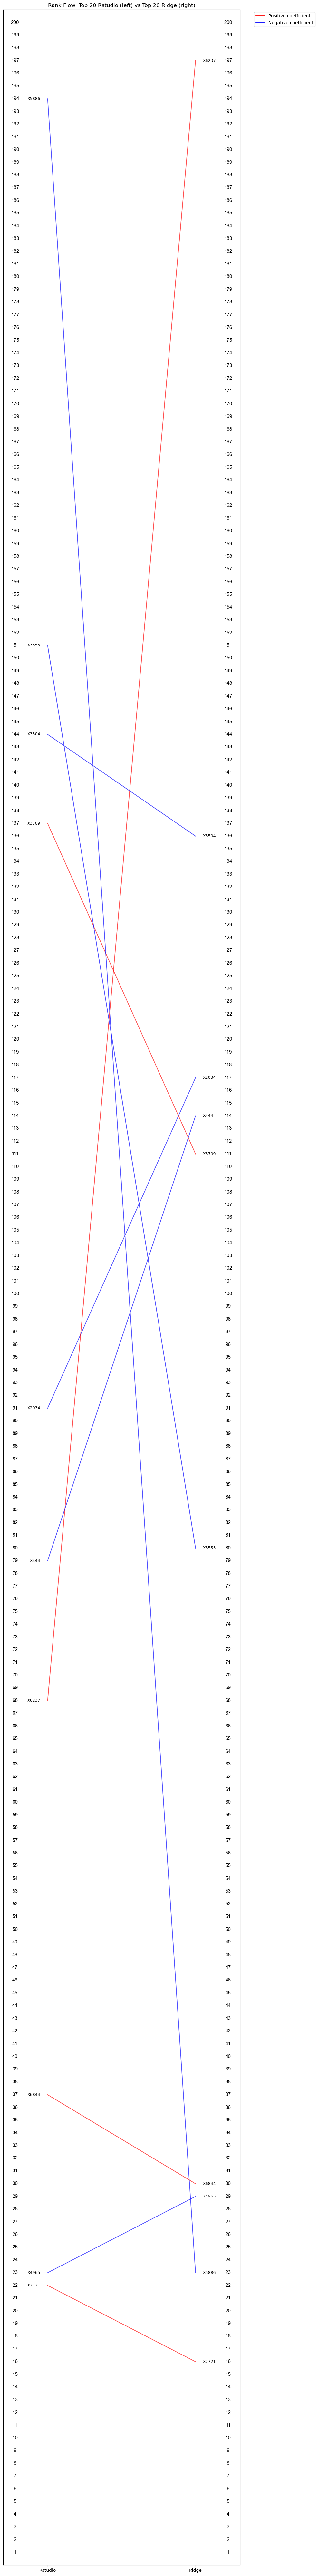

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load coefficient CSVs
ridge = pd.read_csv("subsample_ridge_coefs.csv")
lasso = pd.read_csv("subsample_ridge_coefs_Rstudio.csv")

# Get mean coefficients for each model
ridge_mean = ridge.filter(like='coef_').mean()
lasso_mean = lasso.filter(like='coef_').mean()

# Get top 20 features by absolute value for each model
ridge_top = ridge_mean.abs().sort_values(ascending=False).head(200).index.tolist()
lasso_top = lasso_mean.abs().sort_values(ascending=False).head(200).index.tolist()

def to_label(f): return f'X{int(f.split("_")[1])}'

# Create a DataFrame for all features in either top 20
all_features = list(set(ridge_top + lasso_top))
df = pd.DataFrame({
    'Feature': all_features,
    'Lasso_rank': [lasso_top.index(f) + 1 if f in lasso_top else np.nan for f in all_features],
    'Ridge_rank': [ridge_top.index(f) + 1 if f in ridge_top else np.nan for f in all_features],
    'Label': [to_label(f) for f in all_features],
    'Sign': [ridge_mean[f] if f in ridge_mean else 0 for f in all_features]
})

# Only keep features that are in at least one top 20
df = df.dropna(subset=['Lasso_rank', 'Ridge_rank'], how='all')

# Sort left and right for plotting, and keep only top 20
df_left = df.sort_values('Lasso_rank').reset_index(drop=True).iloc[:200]
df_right = df.sort_values('Ridge_rank').reset_index(drop=True).iloc[:200]

# Create mapping from feature to y-position on each side
left_pos = {f: i for i, f in enumerate(df_left['Feature'])}
right_pos = {f: i for i, f in enumerate(df_right['Feature'])}

plt.figure(figsize=(10, max(len(df_left), len(df_right)) * 0.4))

# Draw lines and feature labels
for _, row in df.iterrows():
    if row['Feature'] in left_pos and row['Feature'] in right_pos:
        y0 = left_pos[row['Feature']]
        y1 = right_pos[row['Feature']]
        color = 'red' if row['Sign'] > 0 else 'blue'
        plt.plot([0, 1], [y0, y1], color=color, alpha=0.7)
        plt.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=9)
        plt.text(1.05, y1, row['Label'], va='center', ha='left', fontsize=9)

# Add rank numbers 1-20 on both sides, spaced and with a different font
for i in range(len(df_left)):
    plt.text(-0.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')
for i in range(len(df_right)):
    plt.text(1.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')

plt.xlim(-0.3, 1.3)
plt.ylim(-1, max(len(df_left), len(df_right)))
plt.xticks([0, 1], ['Rstudio', 'Ridge'])
plt.yticks([])
plt.title('Rank Flow: Top 20 Rstudio (left) vs Top 20 Ridge (right)')
from matplotlib.lines import Line2D
plt.legend([Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='blue', lw=2)],
           ['Positive coefficient', 'Negative coefficient'],
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

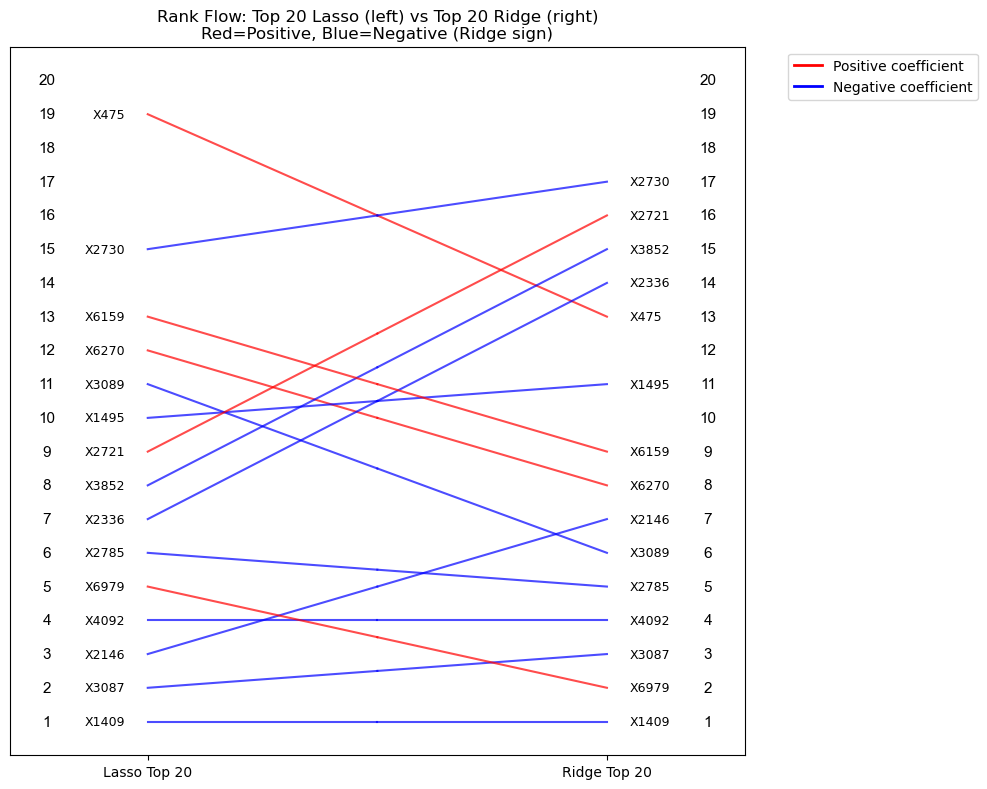

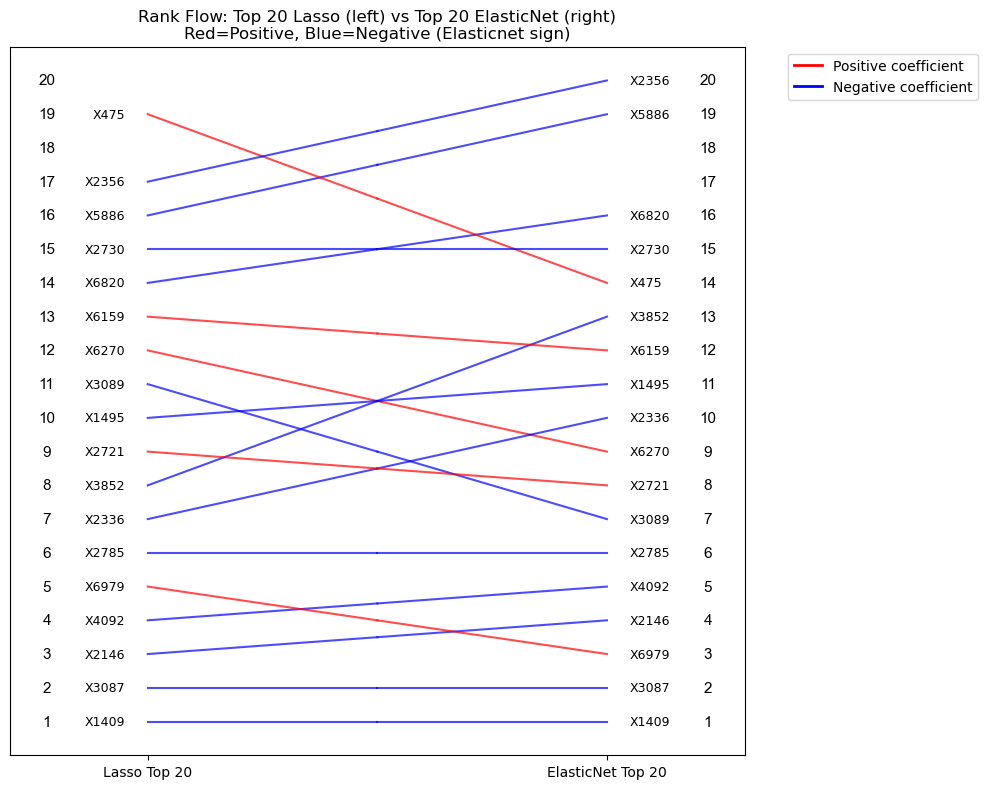

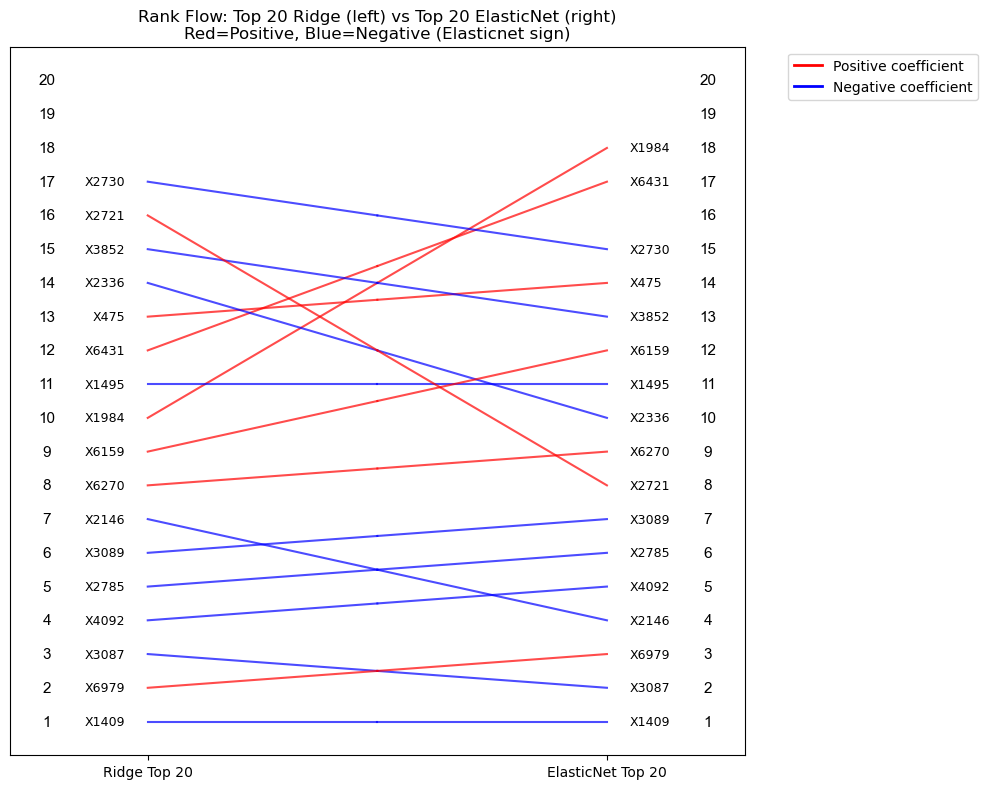

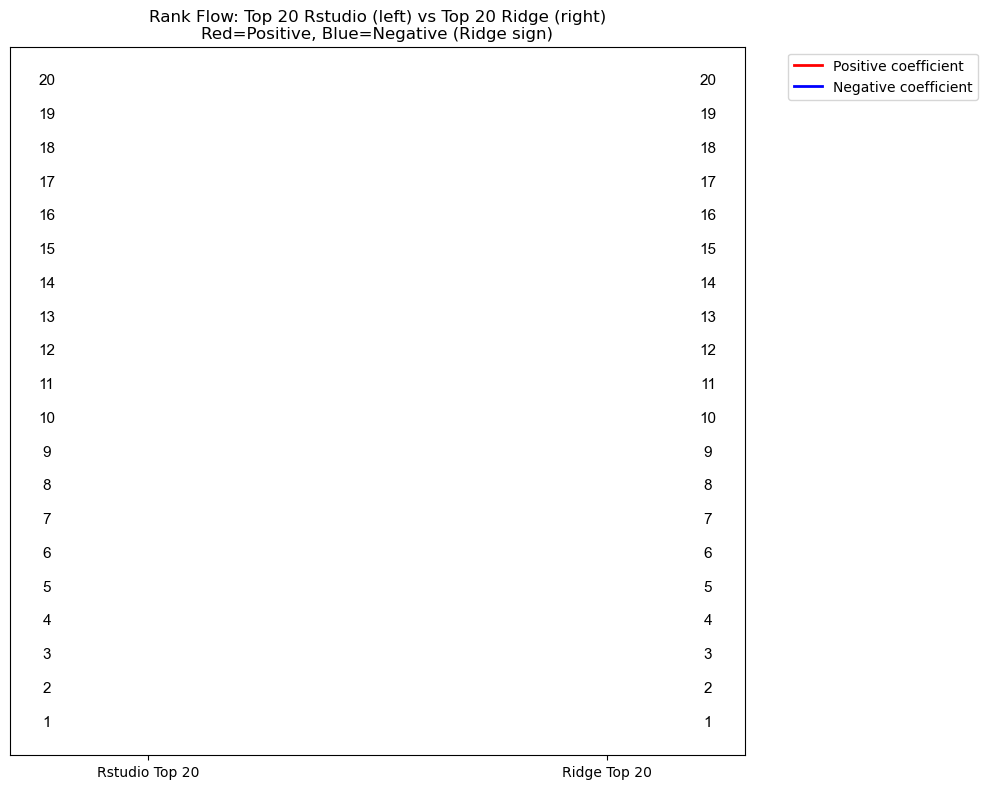

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_rank_flow(model1_name, model2_name, model1_csv, model2_csv, color_sign_model='ridge'):
    # Load coefficient CSVs
    model1 = pd.read_csv(model1_csv)
    model2 = pd.read_csv(model2_csv)

    # Get mean coefficients for each model
    model1_mean = model1.filter(like='coef_').mean()
    model2_mean = model2.filter(like='coef_').mean()

    # Get top 20 features by absolute value for each model
    model1_top = model1_mean.abs().sort_values(ascending=False).head(20).index.tolist()
    model2_top = model2_mean.abs().sort_values(ascending=False).head(20).index.tolist()

    def to_label(f): return f'X{int(f.split("_")[1])}'

    # For color: use Ridge sign by default, else use model1
    if color_sign_model == 'ridge' and model2_name.lower() == 'ridge':
        sign_mean = model2_mean
    elif color_sign_model == 'lasso' and model1_name.lower() == 'lasso':
        sign_mean = model1_mean
    elif color_sign_model == 'elasticnet' and (model1_name.lower() == 'elasticnet' or model2_name.lower() == 'elasticnet'):
        sign_mean = model1_mean if model1_name.lower() == 'elasticnet' else model2_mean
    else:
        sign_mean = model1_mean

    # Create a DataFrame for all features in either top 20
    all_features = list(set(model1_top + model2_top))
    df = pd.DataFrame({
        'Feature': all_features,
        f'{model1_name}_rank': [model1_top.index(f) + 1 if f in model1_top else np.nan for f in all_features],
        f'{model2_name}_rank': [model2_top.index(f) + 1 if f in model2_top else np.nan for f in all_features],
        'Label': [to_label(f) for f in all_features],
        'Sign': [sign_mean[f] if f in sign_mean else 0 for f in all_features]
        
    })

    # Only keep features that are in at least one top 20
    df = df.dropna(subset=[f'{model1_name}_rank', f'{model2_name}_rank'], how='all')

    # Sort left and right for plotting, and keep only top 20
    df_left = df.sort_values(f'{model1_name}_rank').reset_index(drop=True).iloc[:20]
    df_right = df.sort_values(f'{model2_name}_rank').reset_index(drop=True).iloc[:20]

    # Create mapping from feature to y-position on each side
    left_pos = {f: i for i, f in enumerate(df_left['Feature'])}
    right_pos = {f: i for i, f in enumerate(df_right['Feature'])}

    plt.figure(figsize=(10, max(len(df_left), len(df_right)) * 0.4))

    # Draw lines and feature labels
    for _, row in df.iterrows():
        if row['Feature'] in left_pos and row['Feature'] in right_pos:
            y0 = left_pos[row['Feature']]
            y1 = right_pos[row['Feature']]
            # Get sign for both sides
            left_sign = model1_mean[row['Feature']] if row['Feature'] in model1_mean else 0
            right_sign = model2_mean[row['Feature']] if row['Feature'] in model2_mean else 0
            # Midpoint for the line
            x_mid = 0.5
            y_mid = y0 + (y1 - y0) * 0.5
            # Left half (from left to midpoint)
            plt.plot([0, x_mid], [y0, y_mid], color='red' if left_sign > 0 else 'blue', alpha=0.7)
            # Right half (from midpoint to right)
            plt.plot([x_mid, 1], [y_mid, y1], color='red' if right_sign > 0 else 'blue', alpha=0.7)
            plt.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=9)
            plt.text(1.05, y1, row['Label'], va='center', ha='left', fontsize=9)
            
    # Add rank numbers 1-20 on both sides, spaced and with a different font
    for i in range(len(df_left)):
        plt.text(-0.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')
    for i in range(len(df_right)):
        plt.text(1.22, i, str(i+1), va='center', ha='center', fontsize=11, color='black', fontname='Arial')

    plt.xlim(-0.3, 1.3)
    plt.ylim(-1, max(len(df_left), len(df_right)))
    plt.xticks([0, 1], [f'{model1_name} Top 20', f'{model2_name} Top 20'])
    plt.yticks([])
    plt.title(f'Rank Flow: Top 20 {model1_name} (left) vs Top 20 {model2_name} (right)\nRed=Positive, Blue=Negative ({color_sign_model.capitalize()} sign)')
    from matplotlib.lines import Line2D
    plt.legend([Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='blue', lw=2)],
               ['Positive coefficient', 'Negative coefficient'],
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Generate all three plots ---

plot_rank_flow('Lasso', 'Ridge', 'subsample_lasso_coefs.csv', 'subsample_ridge_coefs.csv', color_sign_model='ridge')
plot_rank_flow('Lasso', 'ElasticNet', 'subsample_lasso_coefs.csv', 'subsample_elasticnet_coefs.csv', color_sign_model='elasticnet')
plot_rank_flow('Ridge', 'ElasticNet', 'subsample_ridge_coefs.csv', 'subsample_elasticnet_coefs.csv', color_sign_model='elasticnet')
plot_rank_flow('Rstudio', 'Ridge', 'subsample_ridge_coefs_Rstudio.csv', 'subsample_ridge_coefs.csv', color_sign_model='ridge')

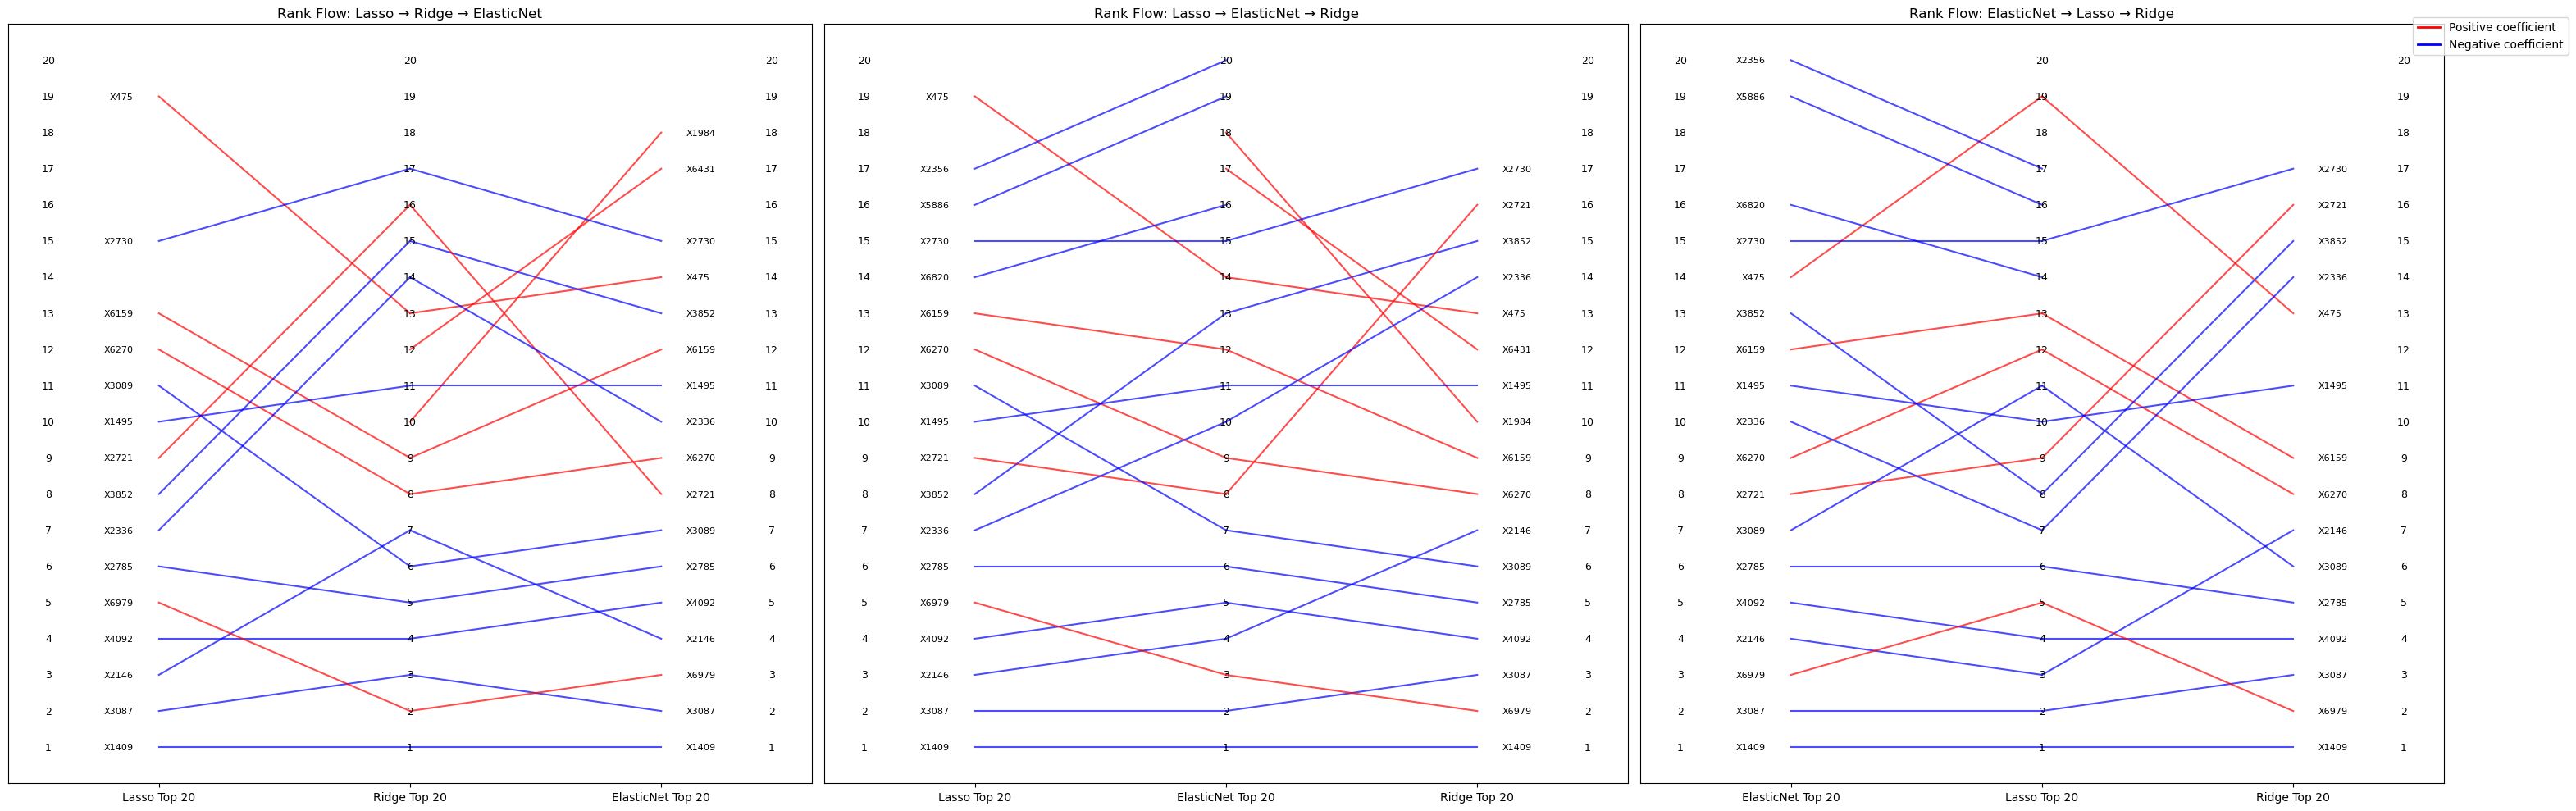

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_rank_flow_three(model_names, model_csvs, color_sign_model='ridge', ax=None):
    # Load coefficient CSVs
    models = [pd.read_csv(csv) for csv in model_csvs]
    means = [m.filter(like='coef_').mean() for m in models]
    tops = [mean.abs().sort_values(ascending=False).head(20).index.tolist() for mean in means]
    def to_label(f): return f'X{int(f.split("_")[1])}'
    # For color: use the sign from the color_sign_model
    color_idx = [name.lower() for name in model_names].index(color_sign_model.lower()) if color_sign_model.lower() in [n.lower() for n in model_names] else 0
    sign_mean = means[color_idx]
    # All features in any top 20
    all_features = list(set(tops[0] + tops[1] + tops[2]))
    df = pd.DataFrame({
        'Feature': all_features,
        f'{model_names[0]}_rank': [tops[0].index(f) + 1 if f in tops[0] else np.nan for f in all_features],
        f'{model_names[1]}_rank': [tops[1].index(f) + 1 if f in tops[1] else np.nan for f in all_features],
        f'{model_names[2]}_rank': [tops[2].index(f) + 1 if f in tops[2] else np.nan for f in all_features],
        'Label': [to_label(f) for f in all_features],
        'Sign': [sign_mean[f] if f in sign_mean else 0 for f in all_features]
    })
    # Only keep features that are in at least one top 20
    df = df.dropna(subset=[f'{model_names[0]}_rank', f'{model_names[1]}_rank', f'{model_names[2]}_rank'], how='all')
    # Sort for plotting, keep only top 20 for each
    df_left = df.sort_values(f'{model_names[0]}_rank').reset_index(drop=True).iloc[:20]
    df_mid = df.sort_values(f'{model_names[1]}_rank').reset_index(drop=True).iloc[:20]
    df_right = df.sort_values(f'{model_names[2]}_rank').reset_index(drop=True).iloc[:20]
    # Mapping from feature to y-position
    left_pos = {f: i for i, f in enumerate(df_left['Feature'])}
    mid_pos = {f: i for i, f in enumerate(df_mid['Feature'])}
    right_pos = {f: i for i, f in enumerate(df_right['Feature'])}
    if ax is None:
        ax = plt.gca()
    # Draw lines and feature labels
    for _, row in df.iterrows():
        if row['Feature'] in left_pos and row['Feature'] in mid_pos:
            y0 = left_pos[row['Feature']]
            y1 = mid_pos[row['Feature']]
            sign0 = means[0][row['Feature']] if row['Feature'] in means[0] else 0
            sign1 = means[1][row['Feature']] if row['Feature'] in means[1] else 0
            ax.plot([0, 0.5], [y0, y1], color='red' if sign0 > 0 else 'blue', alpha=0.7)
            ax.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=8)
        if row['Feature'] in mid_pos and row['Feature'] in right_pos:
            y1 = mid_pos[row['Feature']]
            y2 = right_pos[row['Feature']]
            sign1 = means[1][row['Feature']] if row['Feature'] in means[1] else 0
            sign2 = means[2][row['Feature']] if row['Feature'] in means[2] else 0
            ax.plot([0.5, 1], [y1, y2], color='red' if sign2 > 0 else 'blue', alpha=0.7)
            ax.text(1.05, y2, row['Label'], va='center', ha='left', fontsize=8)
    # Add rank numbers
    for i in range(len(df_left)):
        ax.text(-0.22, i, str(i+1), va='center', ha='center', fontsize=9, color='black')
    for i in range(len(df_mid)):
        ax.text(0.5, i, str(i+1), va='center', ha='center', fontsize=9, color='black')
    for i in range(len(df_right)):
        ax.text(1.22, i, str(i+1), va='center', ha='center', fontsize=9, color='black')
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-1, max(len(df_left), len(df_mid), len(df_right)))
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([f'{model_names[0]} Top 20', f'{model_names[1]} Top 20', f'{model_names[2]} Top 20'])
    ax.set_yticks([])
    ax.set_title(f'Rank Flow: {model_names[0]} → {model_names[1]} → {model_names[2]}')
    # No legend here

# --- Plot all three charts in one figure ---
fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharey=True)

plot_rank_flow_three(['Lasso', 'Ridge', 'ElasticNet'],
                    ['subsample_lasso_coefs.csv', 'subsample_ridge_coefs.csv', 'subsample_elasticnet_coefs.csv'],
                    color_sign_model='ridge', ax=axes[0])

plot_rank_flow_three(['Lasso', 'ElasticNet', 'Ridge'],
                    ['subsample_lasso_coefs.csv', 'subsample_elasticnet_coefs.csv', 'subsample_ridge_coefs.csv'],
                    color_sign_model='elasticnet', ax=axes[1])

plot_rank_flow_three(['ElasticNet', 'Lasso', 'Ridge'],
                    ['subsample_elasticnet_coefs.csv', 'subsample_lasso_coefs.csv', 'subsample_ridge_coefs.csv'],
                    color_sign_model='elasticnet', ax=axes[2])

from matplotlib.lines import Line2D
fig.legend([Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='blue', lw=2)],
           ['Positive coefficient', 'Negative coefficient'],
           bbox_to_anchor=(0.98, 0.98), loc='upper left')

plt.tight_layout()
plt.show()

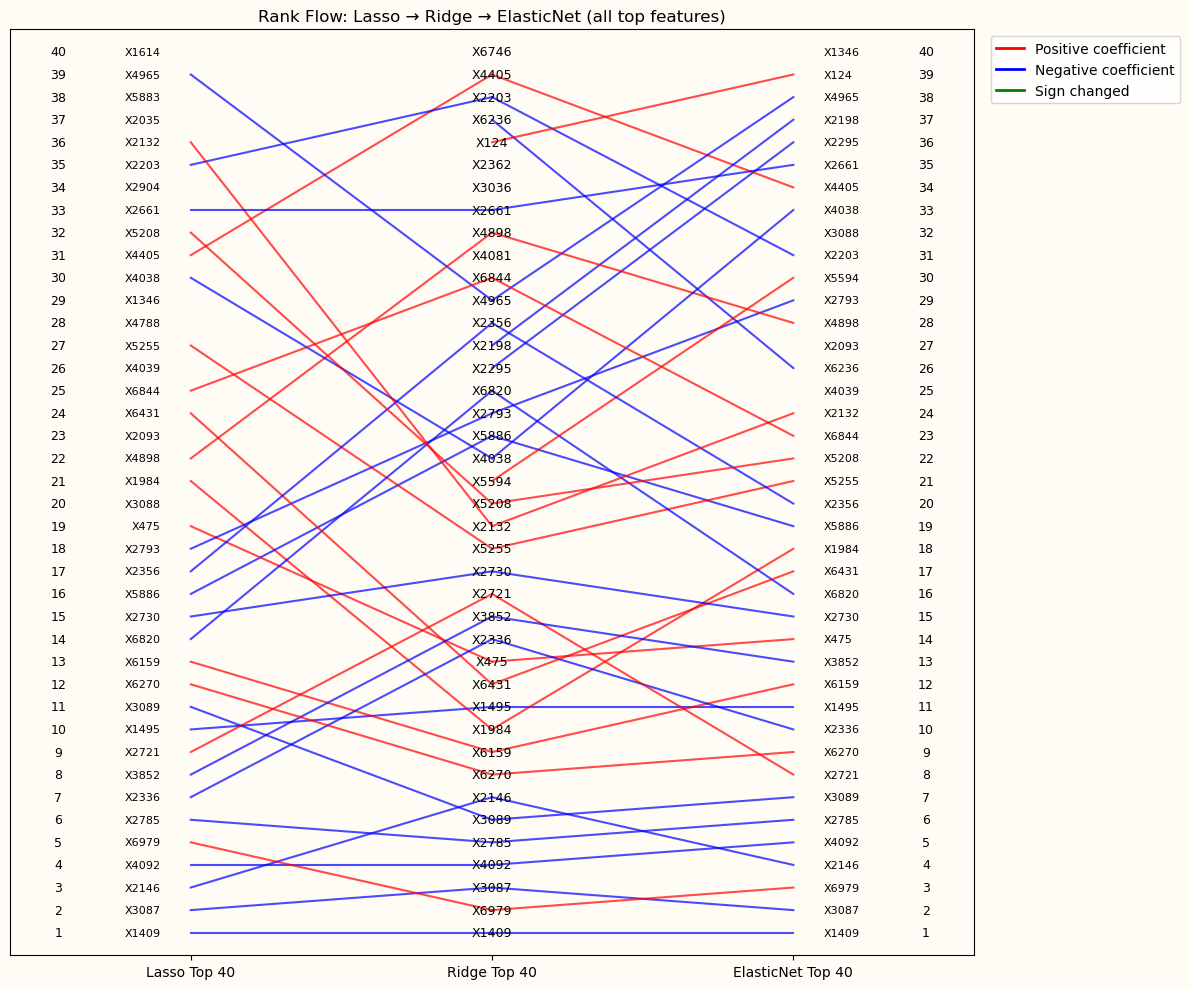

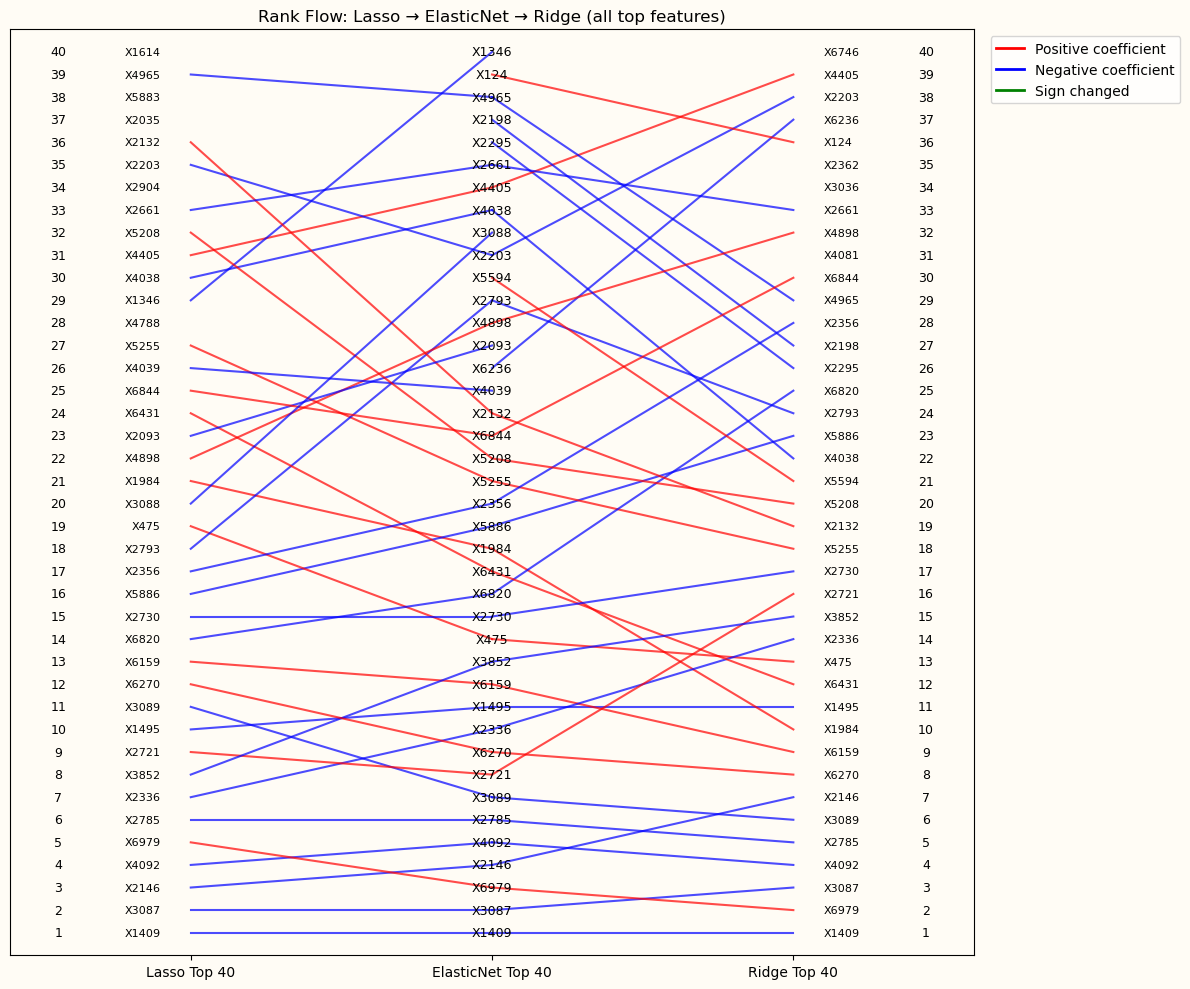

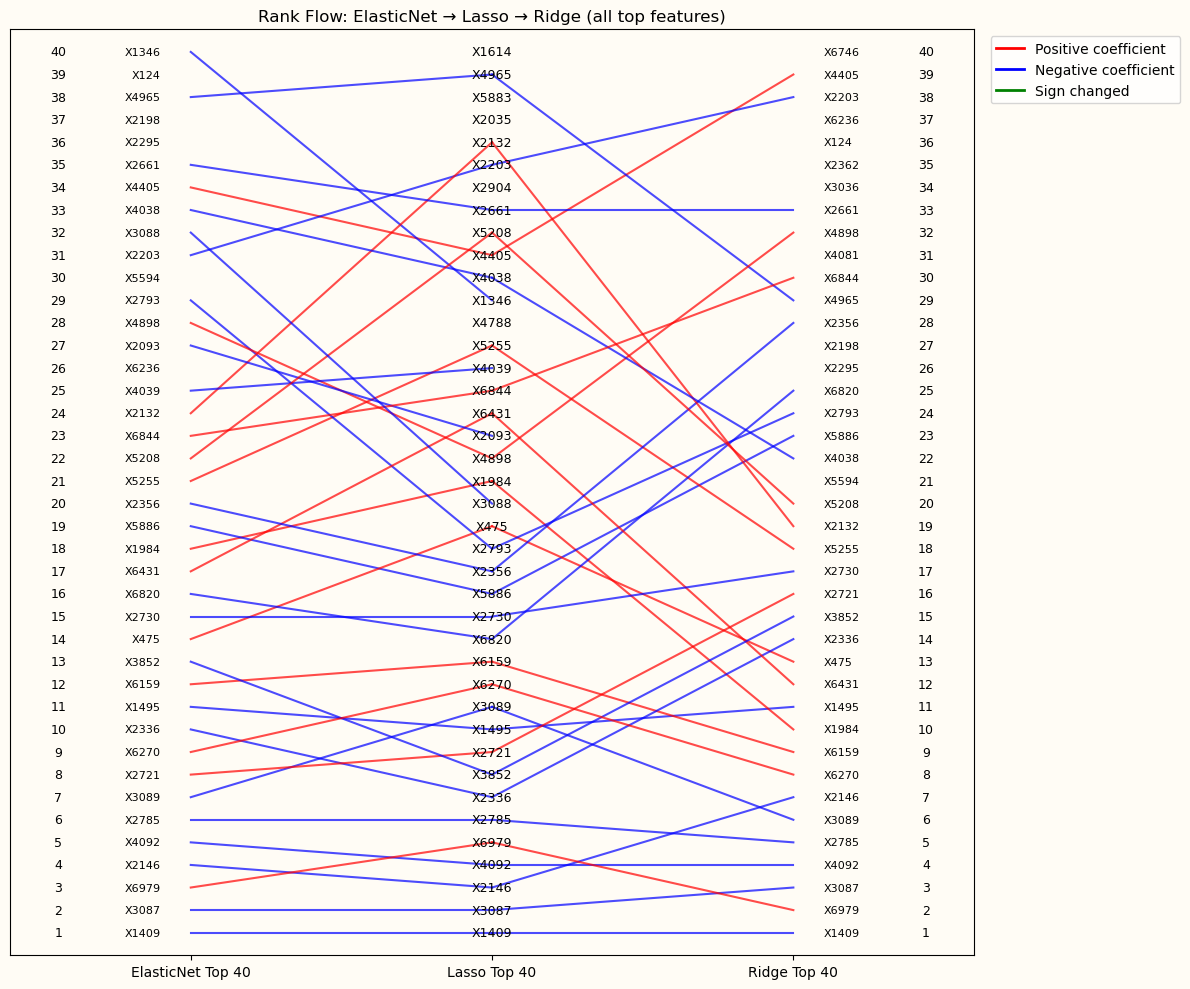

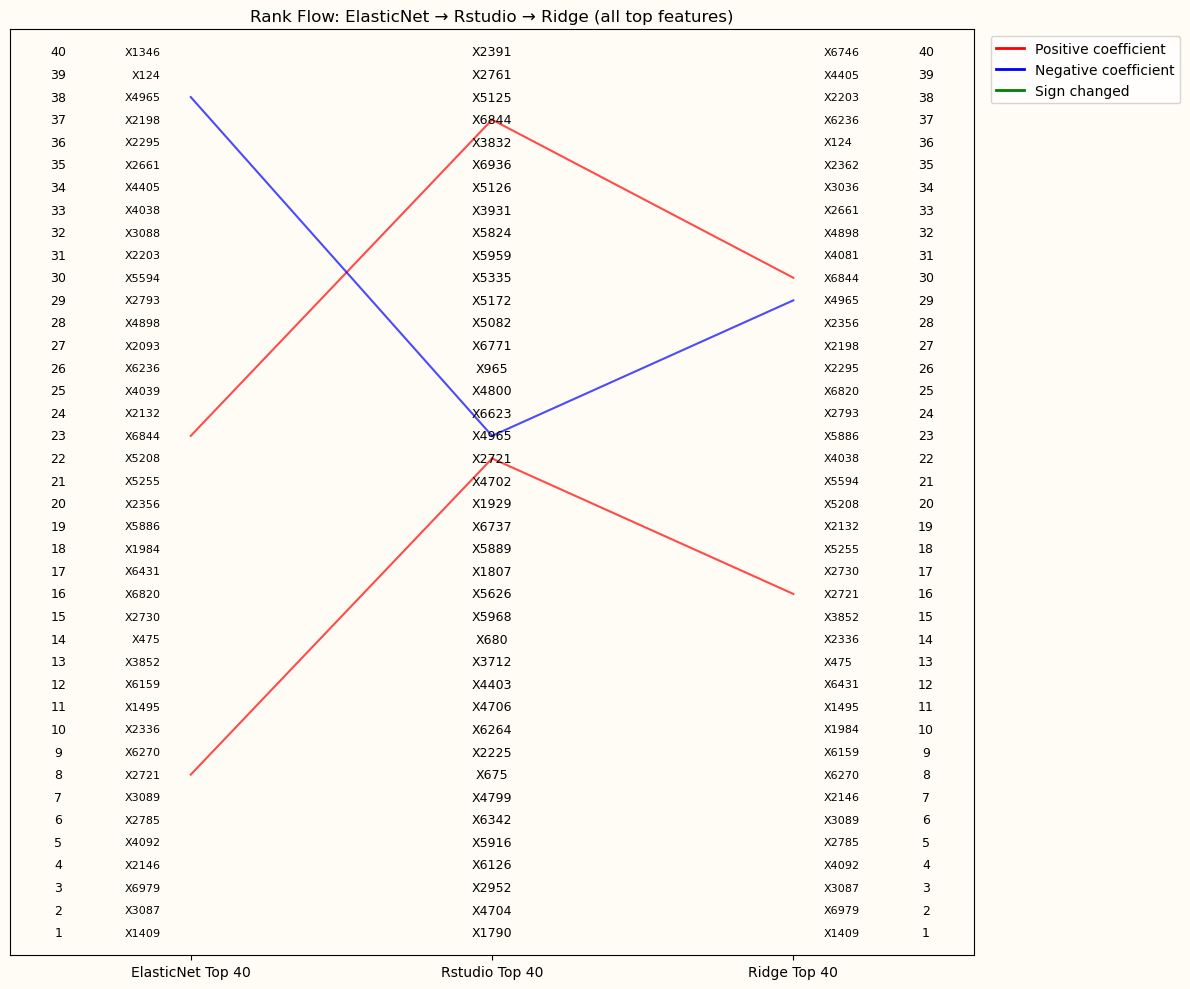

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- User toggles ---
hide_features = 0   # 1 = hide features with no connections, 0 = show all
no_features = 40    # Number of top features per model to display

def plot_rank_flow_three(model_names, model_csvs, color_sign_model='ridge', ax=None,
                         hide_features=1, no_features=20):
    # Load coefficient CSVs
    models = [pd.read_csv(csv) for csv in model_csvs]
    means = [m.filter(like='coef_').mean() for m in models]
    tops = [mean.abs().sort_values(ascending=False).head(no_features).index.tolist() for mean in means]
    def to_label(f): return f'X{int(f.split("_")[1])}'
    # All features in any top N
    all_features = list(set(tops[0] + tops[1] + tops[2]))
    df = pd.DataFrame({
        'Feature': all_features,
        f'{model_names[0]}_rank': [tops[0].index(f) + 1 if f in tops[0] else np.nan for f in all_features],
        f'{model_names[1]}_rank': [tops[1].index(f) + 1 if f in tops[1] else np.nan for f in all_features],
        f'{model_names[2]}_rank': [tops[2].index(f) + 1 if f in tops[2] else np.nan for f in all_features],
        'Label': [to_label(f) for f in all_features]
    })
    # Add sign columns for each model
    df['Sign0'] = [means[0][f] if f in means[0] else 0 for f in all_features]
    df['Sign1'] = [means[1][f] if f in means[1] else 0 for f in all_features]
    df['Sign2'] = [means[2][f] if f in means[2] else 0 for f in all_features]
    # Hide or show features with no connections
    rank_cols = [f'{model_names[0]}_rank', f'{model_names[1]}_rank', f'{model_names[2]}_rank']
    if hide_features:
        df = df[df[rank_cols].notna().sum(axis=1) >= 2]
    # Sort for plotting, keep only top N for each
    df_left = df.sort_values(f'{model_names[0]}_rank').reset_index(drop=True).iloc[:no_features]
    df_mid = df.sort_values(f'{model_names[1]}_rank').reset_index(drop=True).iloc[:no_features]
    df_right = df.sort_values(f'{model_names[2]}_rank').reset_index(drop=True).iloc[:no_features]
    # Mapping from feature to y-position
    left_pos = {f: i for i, f in enumerate(df_left['Feature'])}
    mid_pos = {f: i for i, f in enumerate(df_mid['Feature'])}
    right_pos = {f: i for i, f in enumerate(df_right['Feature'])}
    if ax is None:
        ax = plt.gca()
    # Draw lines and feature labels
    for _, row in df.iterrows():
        # Left to middle
        if row['Feature'] in left_pos and row['Feature'] in mid_pos:
            y0 = left_pos[row['Feature']]
            y1 = mid_pos[row['Feature']]
            sign0 = row['Sign0']
            sign1 = row['Sign1']
            if sign0 * sign1 < 0:
                color = 'green'
            elif sign0 > 0:
                color = 'red'
            else:
                color = 'blue'
            ax.plot([0, 0.5], [y0, y1], color=color, alpha=0.7)
            ax.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=8)
        # Middle to right
        if row['Feature'] in mid_pos and row['Feature'] in right_pos:
            y1 = mid_pos[row['Feature']]
            y2 = right_pos[row['Feature']]
            sign1 = row['Sign1']
            sign2 = row['Sign2']
            if sign1 * sign2 < 0:
                color = 'green'
            elif sign2 > 0:
                color = 'red'
            else:
                color = 'blue'
            ax.plot([0.5, 1], [y1, y2], color=color, alpha=0.7)
            ax.text(1.05, y2, row['Label'], va='center', ha='left', fontsize=8)
        # If feature is only on left or right, still show label
        if row['Feature'] in left_pos and row['Feature'] not in mid_pos:
            y0 = left_pos[row['Feature']]
            ax.text(-0.05, y0, row['Label'], va='center', ha='right', fontsize=8)
        if row['Feature'] in right_pos and row['Feature'] not in mid_pos:
            y2 = right_pos[row['Feature']]
            ax.text(1.05, y2, row['Label'], va='center', ha='left', fontsize=8)
    # Add rank numbers for left, middle, right
    for i in range(len(df_left)):
        ax.text(-0.22, i, str(i+1), va='center', ha='center', fontsize=9, color='black')
    for i, row in df_mid.iterrows():
        ax.text(0.5, i, row['Label'], va='center', ha='center', fontsize=9, color='black')
    for i in range(len(df_right)):
        ax.text(1.22, i, str(i+1), va='center', ha='center', fontsize=9, color='black')
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-1, max(len(df_left), len(df_mid), len(df_right)))
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([f'{model_names[0]} Top {no_features}', f'{model_names[1]} Top {no_features}', f'{model_names[2]} Top {no_features}'])
    ax.set_yticks([])
    # Title reflects options
    if hide_features:
        title_note = " (only features with connections)"
    else:
        title_note = " (all top features)"
    ax.set_title(f'Rank Flow: {model_names[0]} → {model_names[1]} → {model_names[2]}{title_note}')

# Usage example:
# --- Plot 1: Lasso → Ridge → ElasticNet ---
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fffcf5')
plot_rank_flow_three(
    ['Lasso', 'Ridge', 'ElasticNet'],
    ['subsample_lasso_coefs.csv', 'subsample_ridge_coefs.csv', 'subsample_elasticnet_coefs.csv'],
    color_sign_model='ridge',
    ax=ax,
    hide_features=hide_features,
    no_features=no_features
)
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Positive coefficient'),
    Line2D([0], [0], color='blue', lw=2, label='Negative coefficient'),
    Line2D([0], [0], color='green', lw=2, label='Sign changed')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

# --- Plot 2: Lasso → ElasticNet → Ridge ---
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fffcf5')
plot_rank_flow_three(
    ['Lasso', 'ElasticNet', 'Ridge'],
    ['subsample_lasso_coefs.csv', 'subsample_elasticnet_coefs.csv', 'subsample_ridge_coefs.csv'],
    color_sign_model='elasticnet',
    ax=ax,
    hide_features=hide_features,
    no_features=no_features
)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

# --- Plot 3: ElasticNet → Lasso → Ridge ---
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fffcf5')
plot_rank_flow_three(
    ['ElasticNet', 'Lasso', 'Ridge'],
    ['subsample_elasticnet_coefs.csv', 'subsample_lasso_coefs.csv', 'subsample_ridge_coefs.csv'],
    color_sign_model='elasticnet',
    ax=ax,
    hide_features=hide_features,
    no_features=no_features
)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

# --- Plot 4: ElasticNet → Lasso → Ridge ---
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fffcf5')
plot_rank_flow_three(
    ['ElasticNet', 'Rstudio', 'Ridge'],
    ['subsample_elasticnet_coefs.csv', 'subsample_ridge_coefs_Rstudio.csv', 'subsample_ridge_coefs.csv'],
    color_sign_model='elasticnet',
    ax=ax,
    hide_features=hide_features,
    no_features=no_features
)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

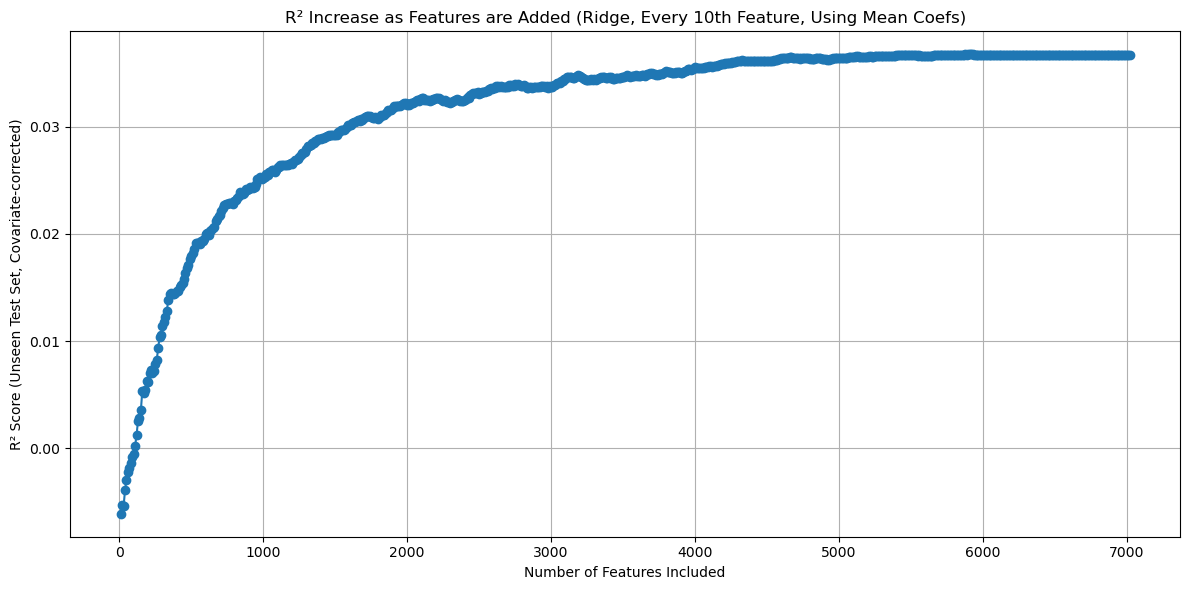

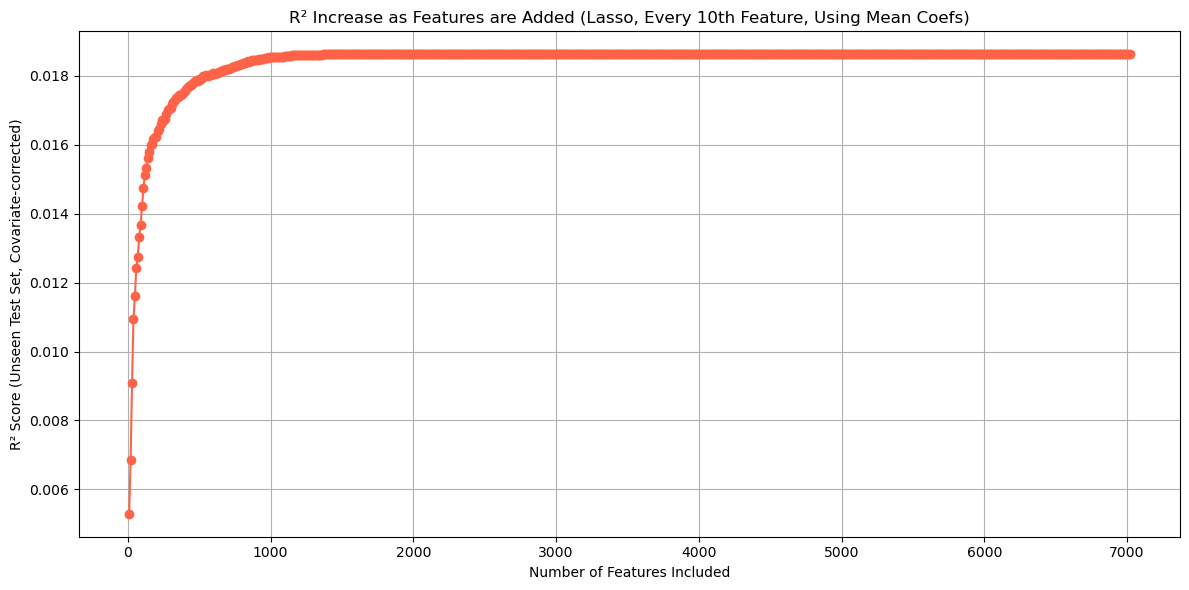

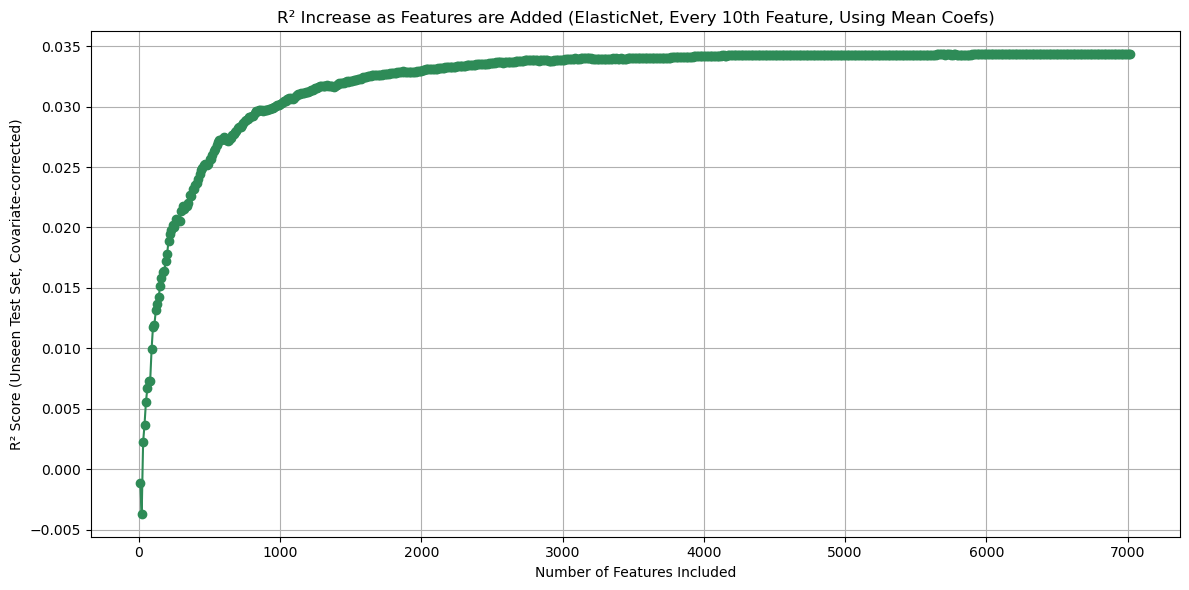

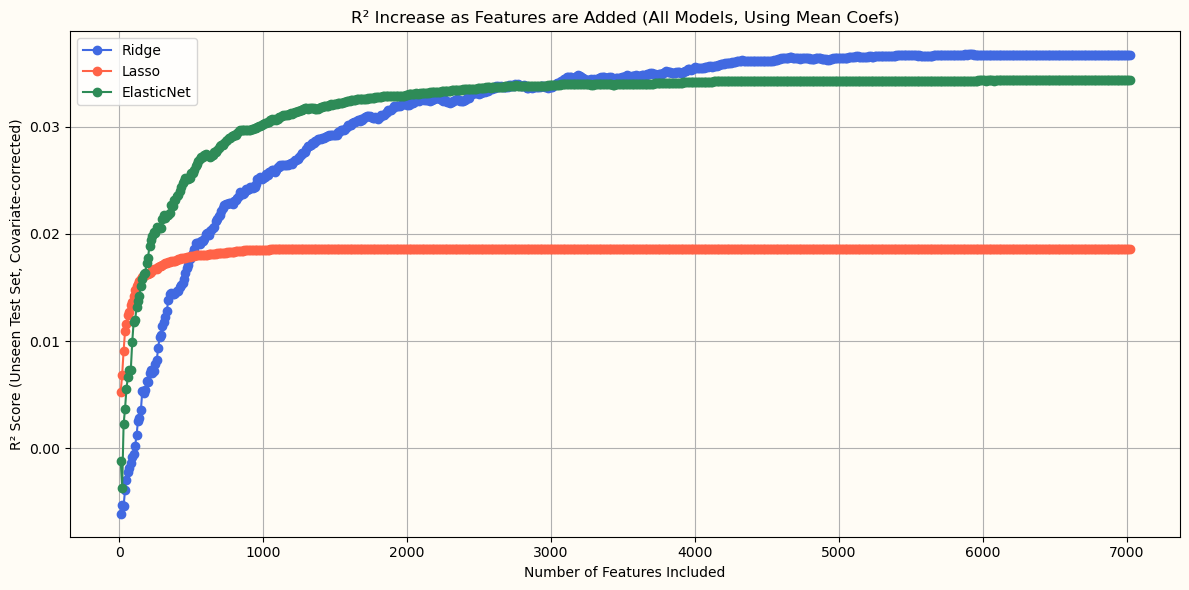

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- Load mean coefficients and intercepts for all models ---
lasso_coefs_df = pd.read_csv("subsample_lasso_coefs.csv")
elastic_coefs_df = pd.read_csv("subsample_elasticnet_coefs.csv")
coef_cols = [col for col in lasso_coefs_df.columns if col.startswith('coef_')]

lasso_mean = lasso_coefs_df[coef_cols].mean(axis=0).values
lasso_intercept = lasso_coefs_df['intercept'].mean()
elastic_mean = elastic_coefs_df[coef_cols].mean(axis=0).values
elastic_intercept = elastic_coefs_df['intercept'].mean()

ridge_coefs_df = pd.read_csv("subsample_ridge_coefs.csv")
coef_cols = [col for col in ridge_coefs_df.columns if col.startswith('coef_')]
ridge_mean = ridge_coefs_df[coef_cols].mean(axis=0).values
ridge_intercept = ridge_coefs_df['intercept'].mean()

# Load training data (for OLS fit)
train_df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_subsample.csv")
train_df = train_df.drop(columns=['time_elapsed'])
train_df = train_df.rename(columns={'nihtbx_totalcomp_uncorrected': 'cc_score'})
X_covariates = [
    'sex', 'r_e_white', 'r_e_black', 'r_e_Hispanic', 'r_e_Asian', 'r_e_Other',
    'interview_age', 'p_e_2ndgrade', 'p_e_3rdgrade', 'p_e_4thgrade', 'p_e_5thgrade',
    'p_e_6thgrade', 'p_e_7thgrade', 'p_e_8thgrade', 'p_e_9thgrade',
    'p_e_10thgrade', 'p_e_11thgrade', 'p_e_12thgrade', 'p_e_highschool',
    'p_e_GED_ediploma', 'p_e_college', 'p_e_adeg_o', 'p_e_adeg_a', 'p_e_ba_deg',
    'p_e_ma_deg', 'p_e_pro_sch', 'p_e_doc_deg', 'p_e_refuse',
    'scanner_disco', 'scanner_ingenia', 'scanner_prisma', 'scanner_prismafit'
]
X_cov_train = train_df[X_covariates].values
y_train = train_df['cc_score'].values

# Fit OLS on training covariates
ols = LinearRegression().fit(X_cov_train, y_train)

# Load test data
test_df = pd.read_csv("F:/New folder/NTU/Semester/MBE Paper/Workspace BHS/clean data/cog_comp_t1_subsample_remainder.csv")
test_df = test_df.drop(columns=['time_elapsed'])
test_df = test_df.rename(columns={'nihtbx_totalcomp_uncorrected': 'cc_score'})
X_columns = [f'X{i}' for i in range(1, 7022)]
X_cov_test = test_df[X_covariates].values
X_test = test_df[X_columns].values
y_test = test_df['cc_score'].values

# Correct test target for covariates
y_test_resid = y_test - ols.predict(X_cov_test)

# --- Ridge ---


# Sort features by importance
sorted_idx = np.argsort(-np.abs(ridge_mean))
X_test_sorted = X_test[:, sorted_idx]
ridge_mean_sorted = ridge_mean[sorted_idx]

r2s = []
feature_counts = list(range(10, len(ridge_mean_sorted) + 1, 10))
for i in feature_counts:
    y_pred = np.dot(X_test_sorted[:, :i], ridge_mean_sorted[:i]) + ridge_intercept
    r2s.append(r2_score(y_test_resid, y_pred))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s, marker='o')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (Ridge, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Lasso ---
sorted_idx_lasso = np.argsort(-np.abs(lasso_mean))
X_test_sorted_lasso = X_test[:, sorted_idx_lasso]
lasso_mean_sorted = lasso_mean[sorted_idx_lasso]

r2s_lasso = []
for i in feature_counts:
    y_pred = np.dot(X_test_sorted_lasso[:, :i], lasso_mean_sorted[:i]) + lasso_intercept
    r2s_lasso.append(r2_score(y_test_resid, y_pred))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_lasso, marker='o', color='tomato')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (Lasso, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ElasticNet ---
sorted_idx_elastic = np.argsort(-np.abs(elastic_mean))
X_test_sorted_elastic = X_test[:, sorted_idx_elastic]
elastic_mean_sorted = elastic_mean[sorted_idx_elastic]

r2s_elastic = []
for i in feature_counts:
    y_pred = np.dot(X_test_sorted_elastic[:, :i], elastic_mean_sorted[:i]) + elastic_intercept
    r2s_elastic.append(r2_score(y_test_resid, y_pred))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_elastic, marker='o', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (ElasticNet, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6), facecolor='#fffcf5')
plt.plot(feature_counts, r2s, marker='o', label='Ridge', color='royalblue')
plt.plot(feature_counts, r2s_lasso, marker='o', label='Lasso', color='tomato')
plt.plot(feature_counts, r2s_elastic, marker='o', label='ElasticNet', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (All Models, Using Mean Coefs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

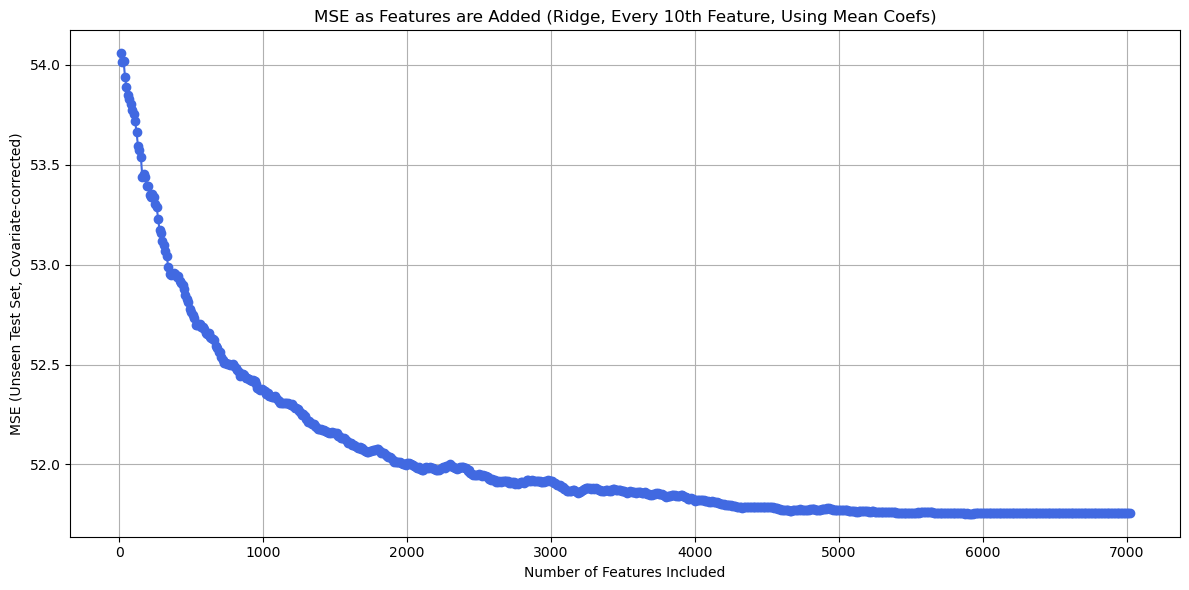

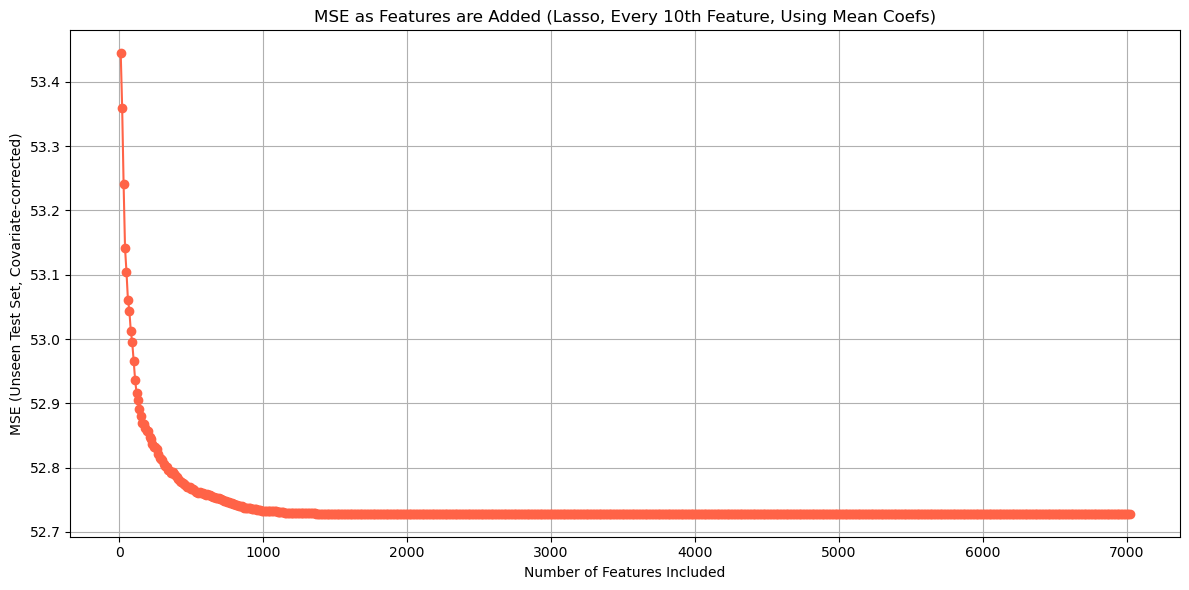

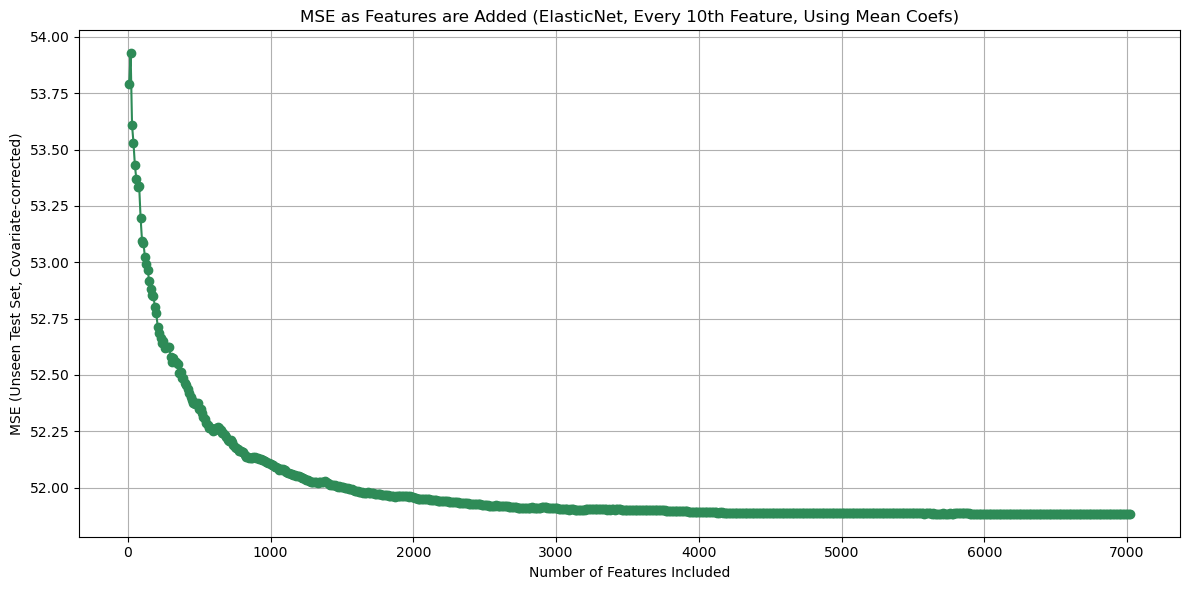

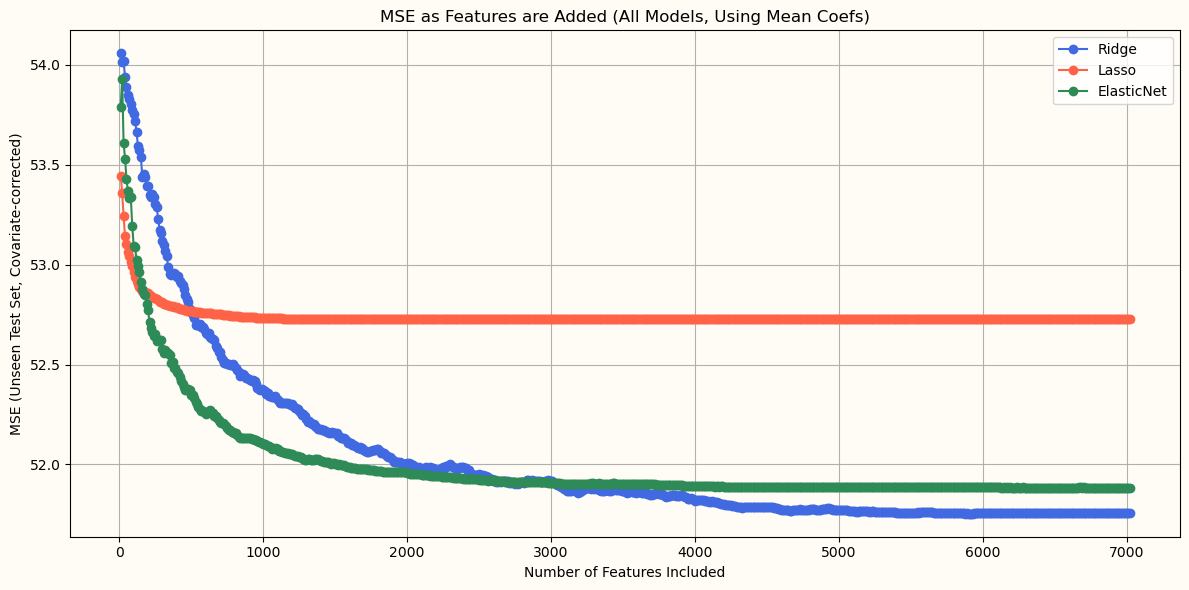

In [2]:
# --- Ridge MSE ---
mse_ridge = []
for i in feature_counts:
    y_pred = np.dot(X_test_sorted[:, :i], ridge_mean_sorted[:i]) + ridge_intercept
    mse_ridge.append(np.mean((y_test_resid - y_pred) ** 2))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_ridge, marker='o', color='royalblue')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (Ridge, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Lasso MSE ---
mse_lasso = []
for i in feature_counts:
    y_pred = np.dot(X_test_sorted_lasso[:, :i], lasso_mean_sorted[:i]) + lasso_intercept
    mse_lasso.append(np.mean((y_test_resid - y_pred) ** 2))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_lasso, marker='o', color='tomato')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (Lasso, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ElasticNet MSE ---
mse_elastic = []
for i in feature_counts:
    y_pred = np.dot(X_test_sorted_elastic[:, :i], elastic_mean_sorted[:i]) + elastic_intercept
    mse_elastic.append(np.mean((y_test_resid - y_pred) ** 2))

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_elastic, marker='o', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (ElasticNet, Every 10th Feature, Using Mean Coefs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Overlay all three MSE curves ---
plt.figure(figsize=(12, 6), facecolor='#fffcf5')
plt.plot(feature_counts, mse_ridge, marker='o', label='Ridge', color='royalblue')
plt.plot(feature_counts, mse_lasso, marker='o', label='Lasso', color='tomato')
plt.plot(feature_counts, mse_elastic, marker='o', label='ElasticNet', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (All Models, Using Mean Coefs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

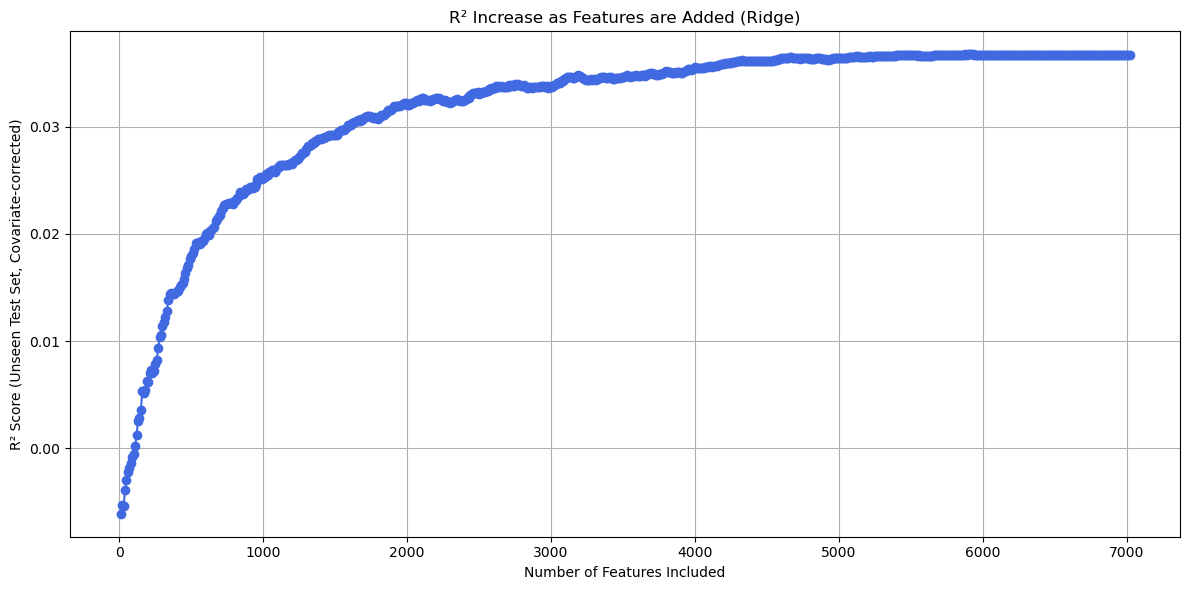

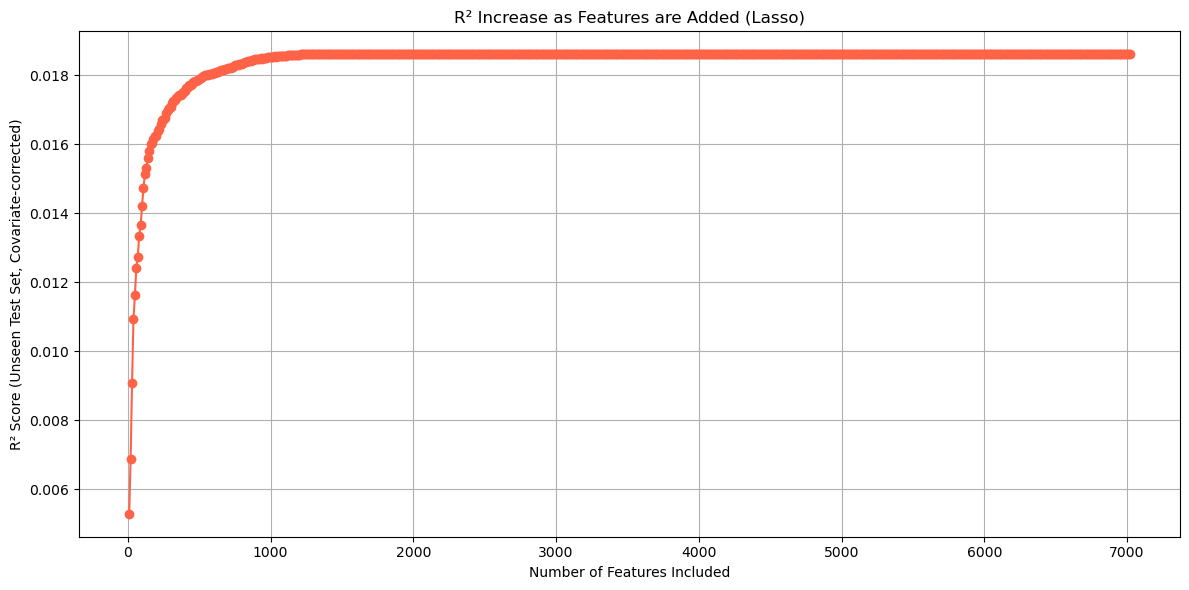

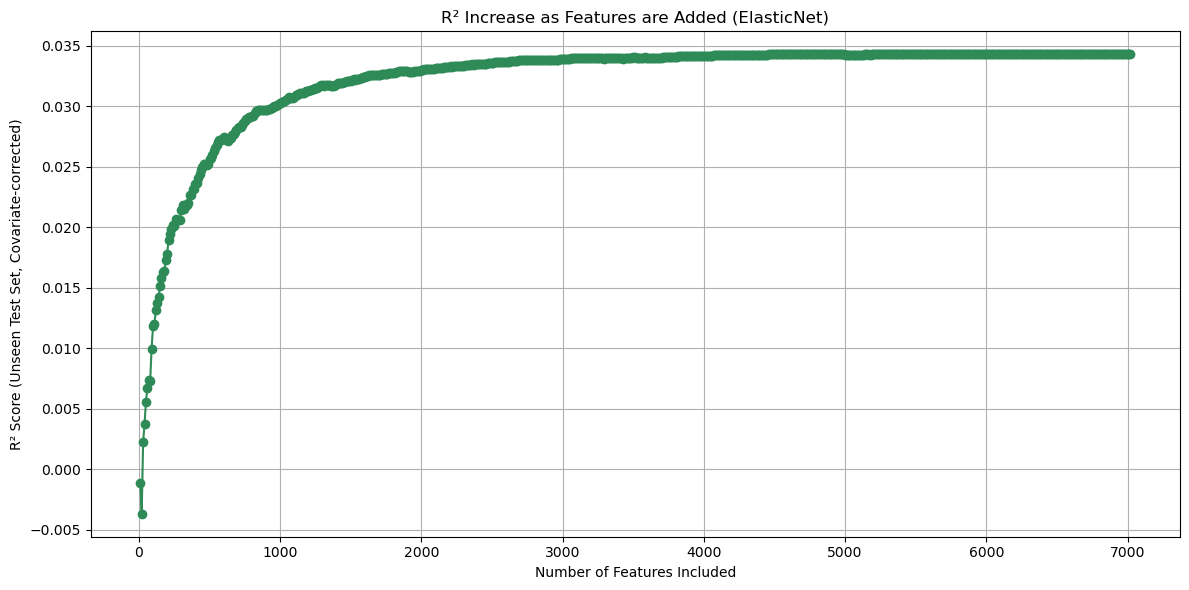

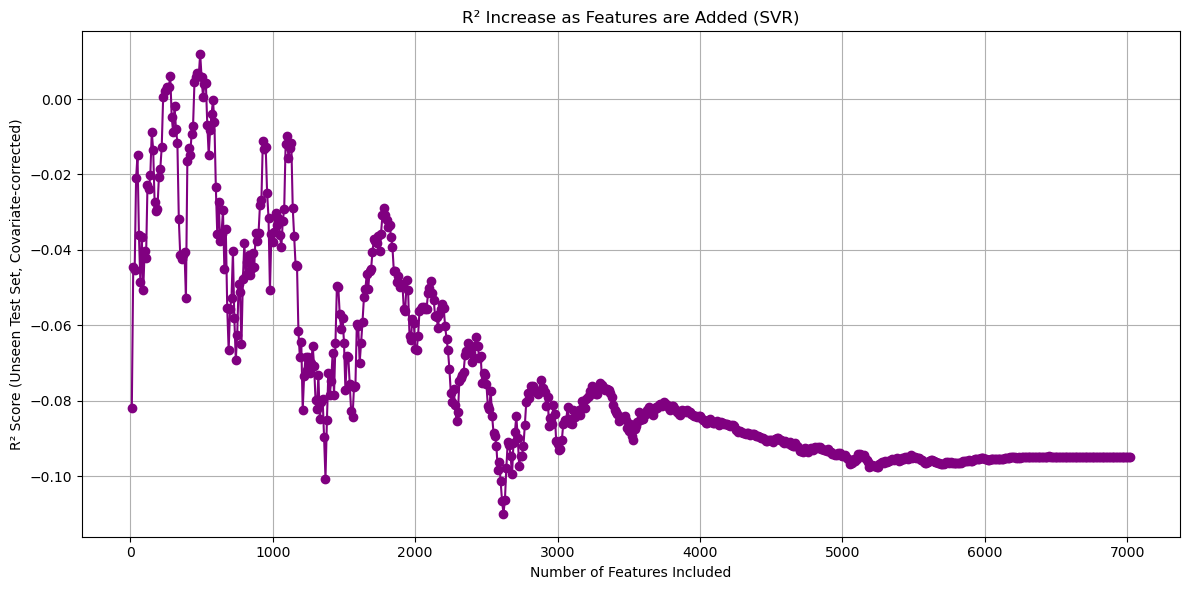

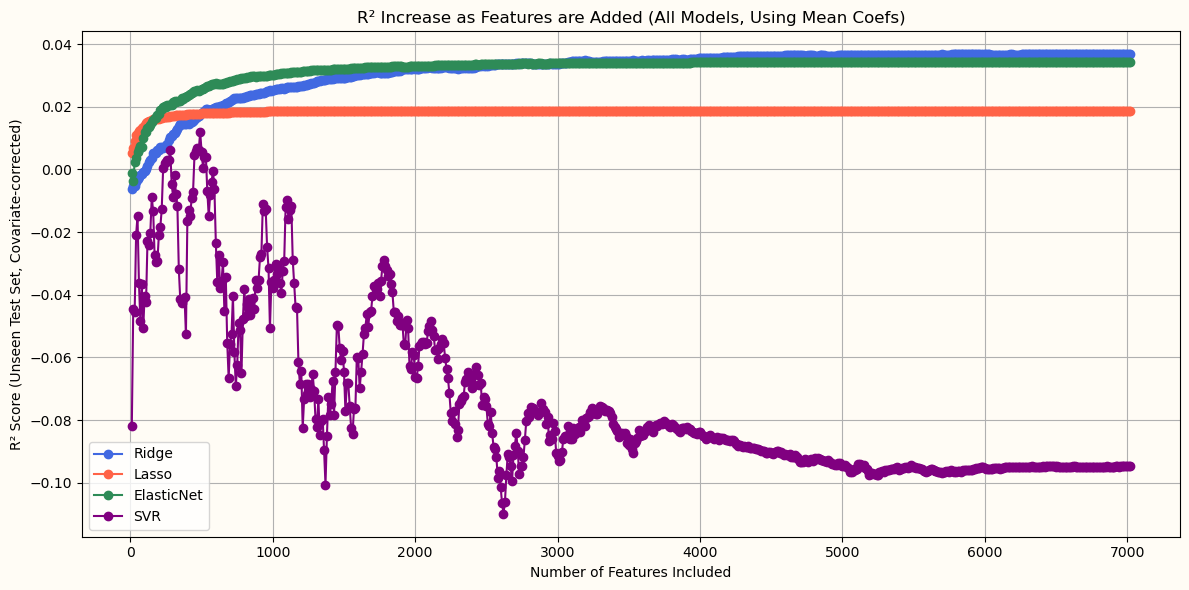

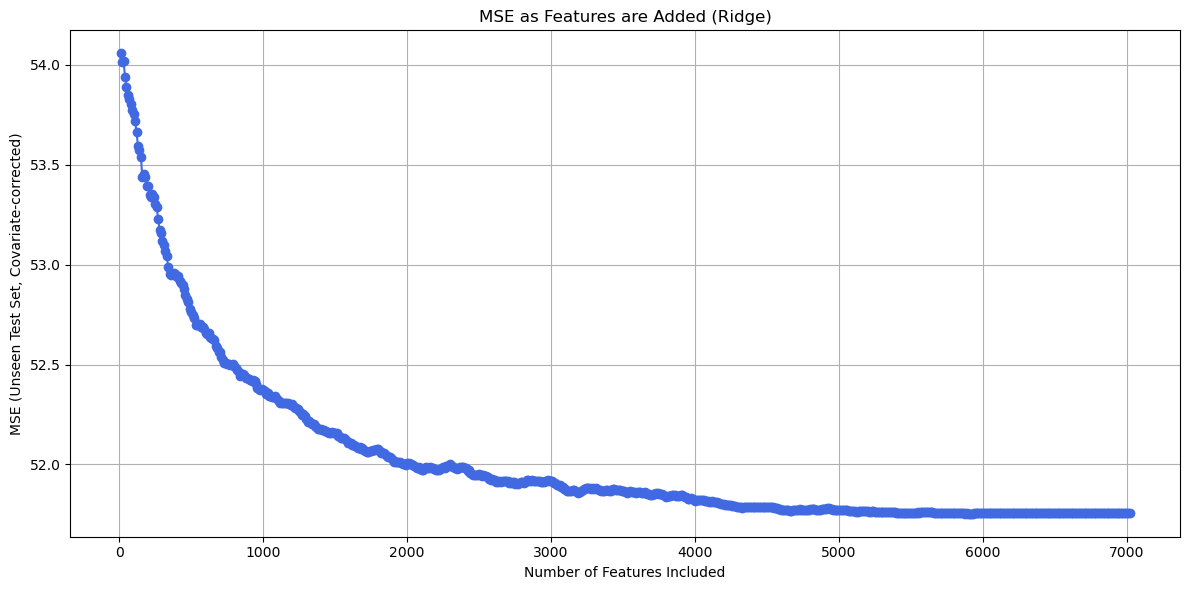

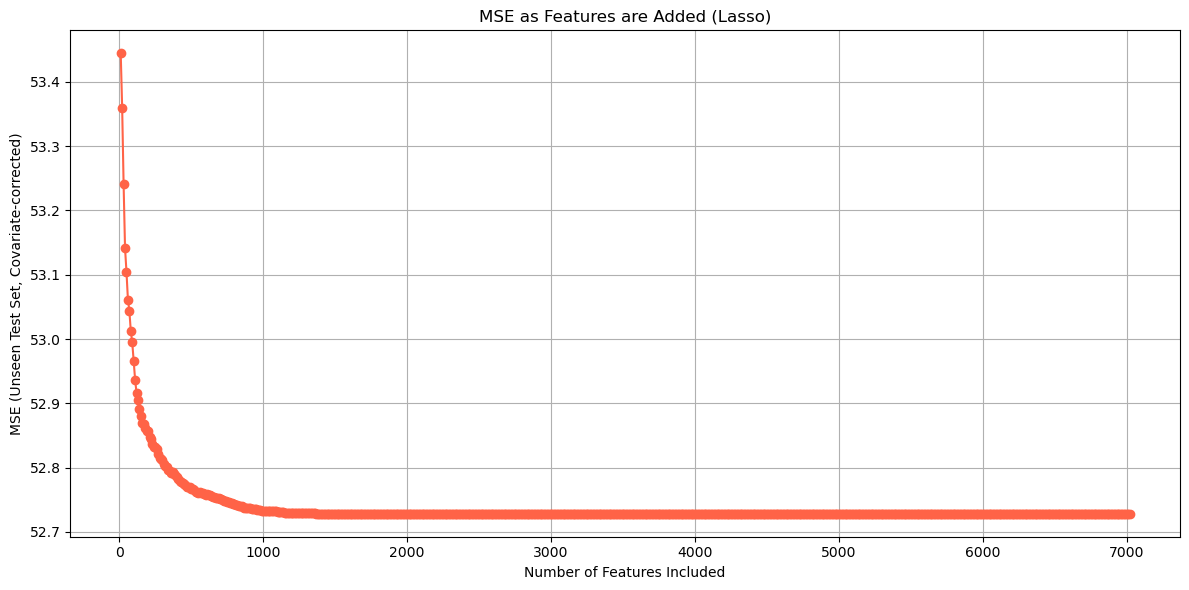

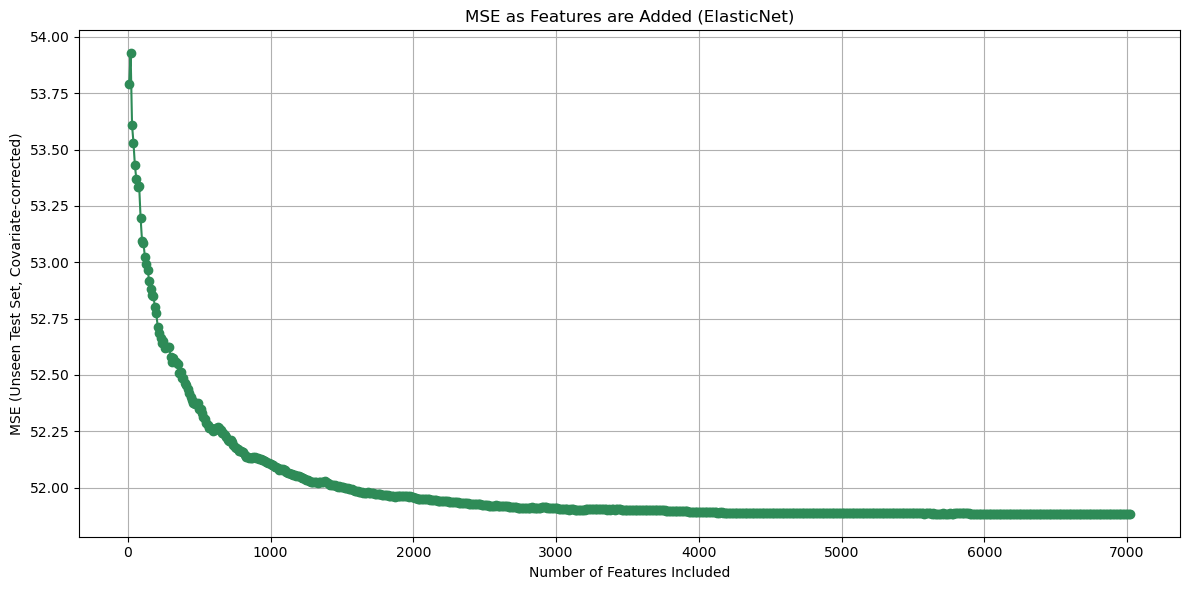

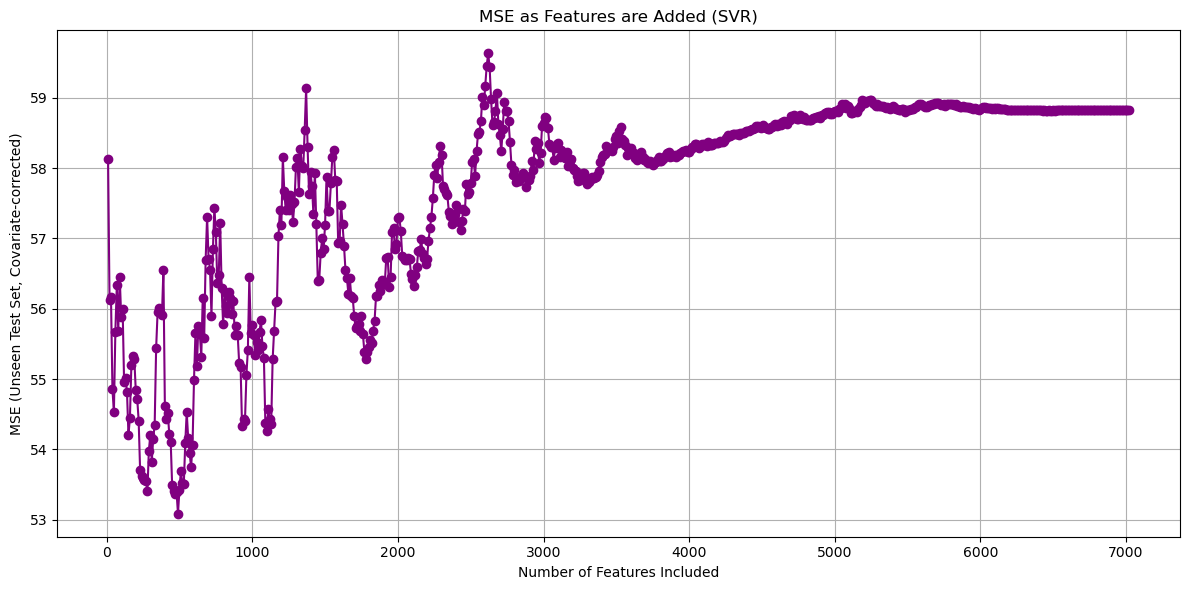

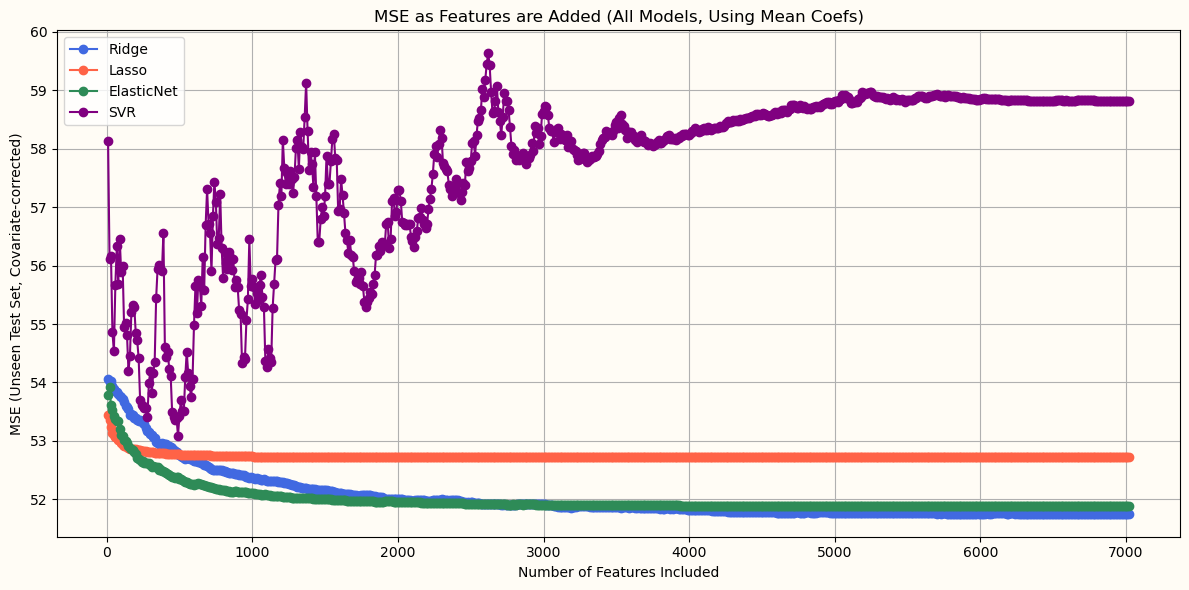

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- SVR mean coefficients and intercept ---
# Assumes SVR was trained with linear kernel and coef_ is available
import joblib
svr_models = joblib.load("subsample_svr_models.joblib")
svr_mean = np.mean([m.coef_.flatten() for m in svr_models], axis=0)
svr_intercept = np.mean([m.intercept_[0] for m in svr_models])

# --- Sort features by importance for each model ---
sorted_idx_ridge = np.argsort(-np.abs(ridge_mean))
sorted_idx_lasso = np.argsort(-np.abs(lasso_mean))
sorted_idx_elastic = np.argsort(-np.abs(elastic_mean))
sorted_idx_svr = np.argsort(-np.abs(svr_mean))

X_test_sorted_ridge = X_test[:, sorted_idx_ridge]
X_test_sorted_lasso = X_test[:, sorted_idx_lasso]
X_test_sorted_elastic = X_test[:, sorted_idx_elastic]
X_test_sorted_svr = X_test[:, sorted_idx_svr]

ridge_mean_sorted = ridge_mean[sorted_idx_ridge]
lasso_mean_sorted = lasso_mean[sorted_idx_lasso]
elastic_mean_sorted = elastic_mean[sorted_idx_elastic]
svr_mean_sorted = svr_mean[sorted_idx_svr]

feature_counts = list(range(10, len(ridge_mean_sorted) + 1, 10))

# --- R² curves ---
r2s_ridge = []
r2s_lasso = []
r2s_elastic = []
r2s_svr = []

for i in feature_counts:
    y_pred_ridge = np.dot(X_test_sorted_ridge[:, :i], ridge_mean_sorted[:i]) + ridge_intercept
    y_pred_lasso = np.dot(X_test_sorted_lasso[:, :i], lasso_mean_sorted[:i]) + lasso_intercept
    y_pred_elastic = np.dot(X_test_sorted_elastic[:, :i], elastic_mean_sorted[:i]) + elastic_intercept
    y_pred_svr = np.dot(X_test_sorted_svr[:, :i], svr_mean_sorted[:i]) + svr_intercept

    r2s_ridge.append(r2_score(y_test_resid, y_pred_ridge))
    r2s_lasso.append(r2_score(y_test_resid, y_pred_lasso))
    r2s_elastic.append(r2_score(y_test_resid, y_pred_elastic))
    r2s_svr.append(r2_score(y_test_resid, y_pred_svr))

# --- Individual R² plots ---
plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_ridge, marker='o', color='royalblue')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (Ridge)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_lasso, marker='o', color='tomato')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (Lasso)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_elastic, marker='o', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (ElasticNet)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, r2s_svr, marker='o', color='purple')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (SVR)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Overlay R² plot ---
plt.figure(figsize=(12, 6), facecolor='#fffcf5')
plt.plot(feature_counts, r2s_ridge, marker='o', label='Ridge', color='royalblue')
plt.plot(feature_counts, r2s_lasso, marker='o', label='Lasso', color='tomato')
plt.plot(feature_counts, r2s_elastic, marker='o', label='ElasticNet', color='seagreen')
plt.plot(feature_counts, r2s_svr, marker='o', label='SVR', color='purple')
plt.xlabel('Number of Features Included')
plt.ylabel('R² Score (Unseen Test Set, Covariate-corrected)')
plt.title('R² Increase as Features are Added (All Models, Using Mean Coefs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

# ==========================
# MSE curves
# ==========================
mse_ridge = []
mse_lasso = []
mse_elastic = []
mse_svr = []

for i in feature_counts:
    y_pred_ridge = np.dot(X_test_sorted_ridge[:, :i], ridge_mean_sorted[:i]) + ridge_intercept
    y_pred_lasso = np.dot(X_test_sorted_lasso[:, :i], lasso_mean_sorted[:i]) + lasso_intercept
    y_pred_elastic = np.dot(X_test_sorted_elastic[:, :i], elastic_mean_sorted[:i]) + elastic_intercept
    y_pred_svr = np.dot(X_test_sorted_svr[:, :i], svr_mean_sorted[:i]) + svr_intercept

    mse_ridge.append(np.mean((y_test_resid - y_pred_ridge) ** 2))
    mse_lasso.append(np.mean((y_test_resid - y_pred_lasso) ** 2))
    mse_elastic.append(np.mean((y_test_resid - y_pred_elastic) ** 2))
    mse_svr.append(np.mean((y_test_resid - y_pred_svr) ** 2))

# --- Individual MSE plots ---
plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_ridge, marker='o', color='royalblue')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (Ridge)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_lasso, marker='o', color='tomato')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (Lasso)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_elastic, marker='o', color='seagreen')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (ElasticNet)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(feature_counts, mse_svr, marker='o', color='purple')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (SVR)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Overlay MSE plot ---
plt.figure(figsize=(12, 6), facecolor='#fffcf5')
plt.plot(feature_counts, mse_ridge, marker='o', label='Ridge', color='royalblue')
plt.plot(feature_counts, mse_lasso, marker='o', label='Lasso', color='tomato')
plt.plot(feature_counts, mse_elastic, marker='o', label='ElasticNet', color='seagreen')
plt.plot(feature_counts, mse_svr, marker='o', label='SVR', color='purple')
plt.xlabel('Number of Features Included')
plt.ylabel('MSE (Unseen Test Set, Covariate-corrected)')
plt.title('MSE as Features are Added (All Models, Using Mean Coefs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().set_facecolor('#fffcf5')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# --- Load labels and coefficients ---
labels = pd.read_csv('7021Labels.csv')
ridge_coefs_df = pd.read_csv("subsample_ridge_coefs.csv")  # or lasso, elasticnet, etc.

# --- Compute mean coefficients ---
coef_cols = [col for col in ridge_coefs_df.columns if col.startswith('coef_')]
mean_coefs = ridge_coefs_df[coef_cols].mean(axis=0).values

# --- Merge with labels ---
labels['coef'] = mean_coefs

# --- Interactive widget for top N or percentage ---
def plot_connectogram(top_n=50, by_percent=False):
    if by_percent:
        n = int(len(labels) * top_n / 100)
    else:
        n = top_n
    # Select top N features by absolute coefficient
    top = labels.iloc[np.argsort(-np.abs(labels['coef']))[:n]]
    regions = pd.unique(top[['Region1', 'Region2']].values.ravel())
    region_idx = {r: i for i, r in enumerate(regions)}
    theta = np.linspace(0, 2*np.pi, len(regions), endpoint=False)
    region_pos = {r: (np.cos(t), np.sin(t)) for r, t in zip(regions, theta)}
    
    plt.figure(figsize=(8,8))
    # Draw nodes
    for r, (x, y) in region_pos.items():
        plt.scatter(x, y, s=200, color='lightgray')
        plt.text(x*1.1, y*1.1, r, ha='center', va='center', fontsize=8)
    # Draw connections
    for _, row in top.iterrows():
        r1, r2, coef = row['Region1'], row['Region2'], row['coef']
        x1, y1 = region_pos[r1]
        x2, y2 = region_pos[r2]
        color = 'red' if coef > 0 else 'blue'
        plt.plot([x1, x2], [y1, y2], color=color, alpha=0.7, linewidth=2 + 3*np.abs(coef)/np.max(np.abs(top['coef'])))
    plt.axis('off')
    plt.title(f'Connectogram: Top {n} Features')
    plt.show()

# --- Widgets for user control ---
n_slider = widgets.IntSlider(value=50, min=1, max=300, step=1, description='Top N:')
percent_toggle = widgets.Checkbox(value=False, description='Use % of features')

def update_plot(top_n, by_percent):
    plot_connectogram(top_n, by_percent)

widgets.interact(update_plot, top_n=n_slider, by_percent=percent_toggle)

interactive(children=(IntSlider(value=50, description='Top N:', max=300, min=1), Checkbox(value=False, descrip…

<function __main__.update_plot(top_n, by_percent)>